<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Final_Short_Term_Traffic_Prediction_using_SAE_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
prediction_model = keras.models.load_model('best_prediction_model_full.keras')

In [ ]:
autoencoder = keras.models.load_model('best_model_full.keras')
autoencoder.load_weights("best_weights.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
controller_data_test = pd.read_csv('Combined flows test.csv')
controller_data_test.dropna(how='all', inplace=True)

controller_data_train = pd.read_csv('Combined flows train.csv')
controller_data_train.dropna(how='all', inplace=True)

In [ ]:
controller_data_train["5 Minutes"] = pd.to_datetime(controller_data_train["5 Minutes"])
controller_data_train.set_index("5 Minutes", inplace=True)
train_flow = controller_data_train[['MADOR Flow (Veh/5 Minutes)', 'THIRD Flow (Veh/5 Minutes)', '11TH Flow (Veh/5 Minutes)', 'ADAMS Flow (Veh/5 Minutes)', 'KING BLVD Flow (Veh/5 Minutes)']]


controller_data_test["5 Minutes"] = pd.to_datetime(controller_data_test["5 Minutes"])
controller_data_test.set_index("5 Minutes", inplace=True)
test_flow = controller_data_test[['MADOR Flow (Veh/5 Minutes)', 'THIRD Flow (Veh/5 Minutes)', '11TH Flow (Veh/5 Minutes)', 'ADAMS Flow (Veh/5 Minutes)', 'KING BLVD Flow (Veh/5 Minutes)']]

In [ ]:
# Normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train_flow)
test = scaler.transform(test_flow)

In [ ]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 12

# [samples, time steps, features]
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [ ]:
# Extract the encoder model
encoder = keras.models.Model(inputs=autoencoder.input,
                             outputs=autoencoder.get_layer('encoder_output').output)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_test)

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
encoded_features = encoded_features.reshape(encoded_features.shape[0], 1, encoded_features.shape[1])
encoded_features_val = encoded_features_val.reshape(encoded_features_val.shape[0], 1, encoded_features_val.shape[1])

In [ ]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Inverse transform the predictions to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
import numpy as np

# Define evaluation metric functions
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Function to evaluate model performance
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mre = mean_relative_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Relative Error (MRE): {mre:.4%}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Example Usage:
# Replace y_test and y_pred with actual test labels and predictions
# y_test = np.array([...])  # Actual traffic flow values
# y_pred = np.array([...])  # Predicted traffic flow values
evaluate_model(np.array(y_test_rescaled), np.array(y_pred_rescaled))


Mean Absolute Error (MAE): 28.5203
Mean Relative Error (MRE): 8.3377%
Root Mean Squared Error (RMSE): 39.5490


2012


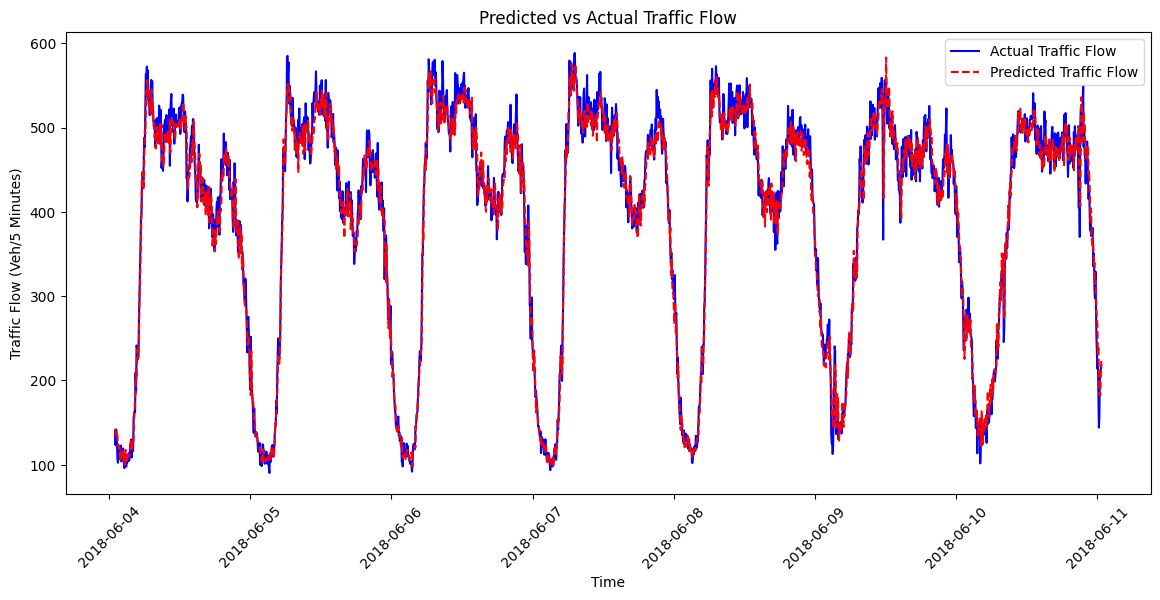

In [ ]:
# timestamps from validation set.
timestamps = test_flow.index[-len(y_test):]

mean_predicted = np.mean(y_pred_rescaled, axis=1)
mean_test = np.mean(y_test_rescaled, axis=1)

week = int(len(timestamps)/4)
print(week)
# 287 timestamps in 1 day
plt.figure(figsize=(14, 6))
plt.plot(timestamps[:week], mean_test[:week], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps[:week], mean_predicted[:week], label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Traffic Flow (Veh/5 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.savefig("avg_predicted_plots.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
detector_cols = [f"Detector{i+1}" for i in range(5)]

# Create a DataFrame
df = pd.DataFrame(y_test_rescaled, columns=detector_cols)

# 1. Create an AverageFlow column across all detectors.
df['AverageFlow'] = df[['Detector1', 'Detector2', 'Detector3', 'Detector4', 'Detector5']].mean(axis=1)

In [ ]:
def compute_error_metrics(y_true, y_pred):
    """Compute MAE, MRE, and RMSE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mre = 100* np.mean(np.abs(y_true - y_pred) / np.abs(y_true))
    mape = 100 * np.mean(np.abs((y_true - y_pred) / (y_true)))

    return mae, mre, rmse, mape

# Use first day (287 samples) for evaluation
n_samples_day = 287
metrics = {}
for detector in range(5):
    y_true = y_test_rescaled[:, detector]
    y_pred = y_pred_rescaled[:, detector]
    mae, mre, rmse, mape = compute_error_metrics(y_true, y_pred)
    metrics[f'Detector {detector+1}'] = {'MAE': mae, 'MRE': mre, 'RMSE': rmse, "MAPE": mape}

print("Error Metrics for the Test Data (per detector):")
print(pd.DataFrame(metrics).T)

Error Metrics for the Test Data (per detector):
                  MAE        MRE       RMSE       MAPE
Detector 1  22.636772   8.803360  30.527594   8.803360
Detector 2  18.235728   8.589558  25.366444   8.589558
Detector 3  33.730633   7.319039  44.191800   7.319039
Detector 4  43.348821  10.308671  56.517763  10.308671
Detector 5  24.649342   6.667745  33.136798   6.667745


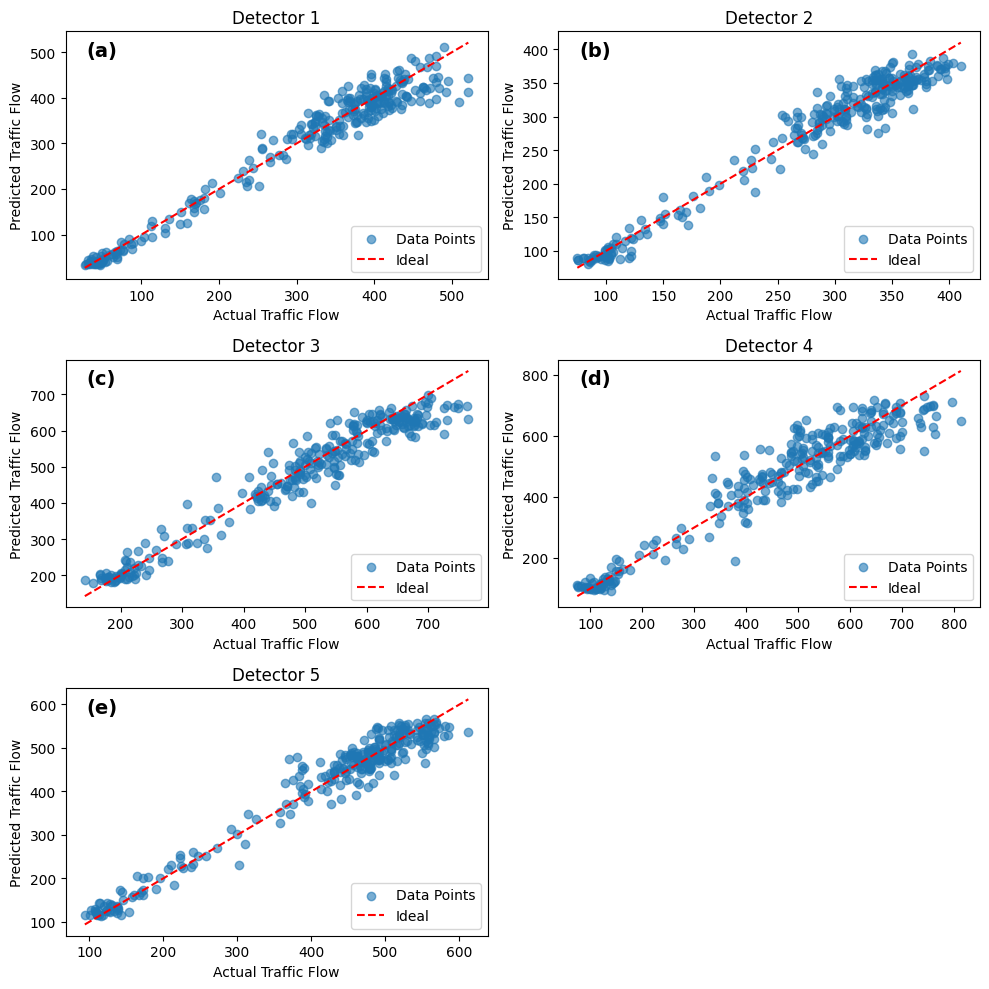

In [ ]:
import matplotlib.pyplot as plt

# ------------------------------
# 2. Scatter Plots: Predicted vs Actual (First Day)
# ------------------------------

plt.figure(figsize=(10, 10))
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']  # Labels for subplots

for detector in range(5):
    plt.subplot(3, 2, detector+1)
    plt.scatter(y_test_rescaled[275:275 + (n_samples_day), detector],
                y_pred_rescaled[275:275 + (n_samples_day), detector],
                alpha=0.6, label='Data Points')
    plt.xlabel('Actual Traffic Flow')
    plt.ylabel('Predicted Traffic Flow')
    plt.title(f'Detector {detector+1}')

    # Plot a 45-degree reference line
    min_val = min(y_test_rescaled[275:275 + (n_samples_day), detector].min(),
                  y_pred_rescaled[275:275 + (n_samples_day), detector].min())
    max_val = max(y_test_rescaled[275:275 + (n_samples_day), detector].max(),
                  y_pred_rescaled[275:275 + (n_samples_day), detector].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')

    # Add subplot label (a), (b), etc.
    plt.text(0.05, 0.9, subplot_labels[detector], transform=plt.gca().transAxes,
             fontsize=14, fontweight='bold')

    plt.legend()

plt.tight_layout()
plt.savefig("scatter_plots.png", dpi=300, bbox_inches='tight')
plt.show()

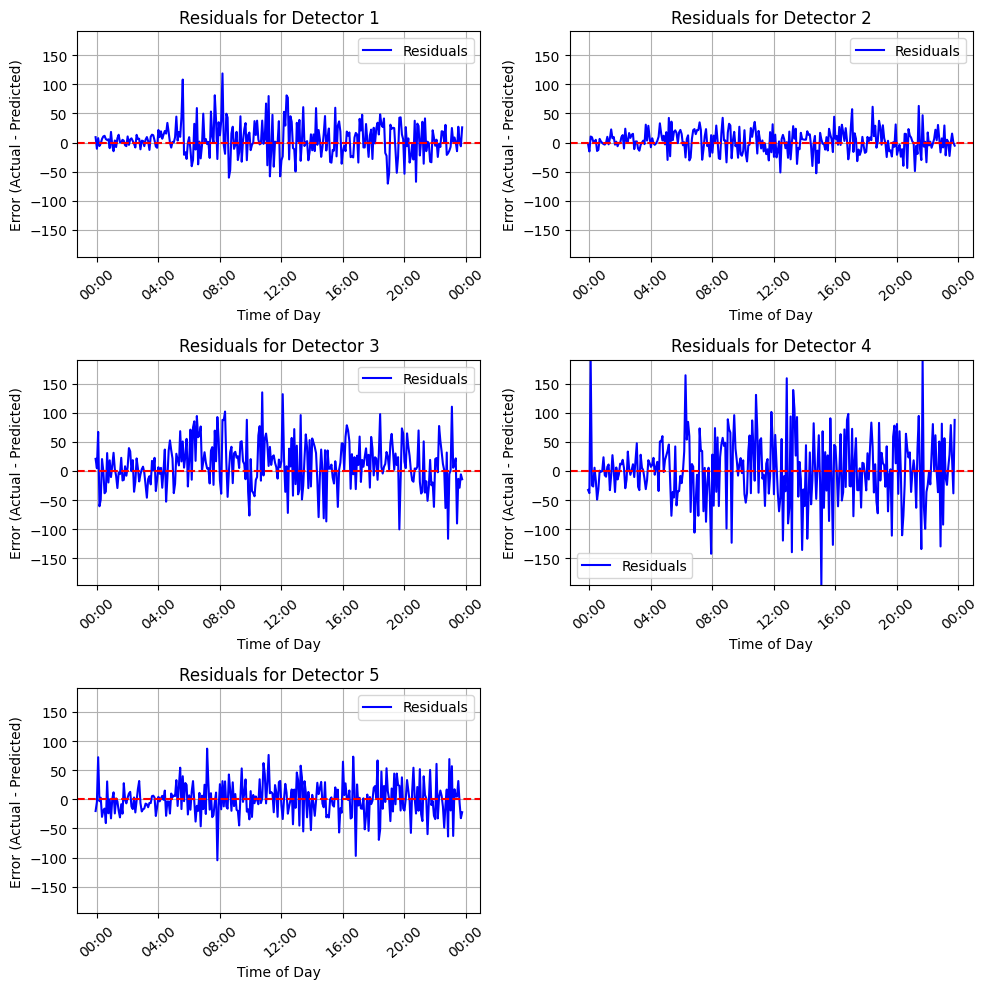

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ------------------------------
# 3. Residual Plots: Error over Time (First Day)
# ------------------------------

# Step 1: Compute global y-limits for all detectors
all_residuals = []
for detector in range(5):
    residuals = y_test_rescaled[275:275 + (n_samples_day), detector] - y_pred_rescaled[275:275 + (n_samples_day), detector]
    all_residuals.append(residuals)

# Find the global min/max across all detectors
y_min = min(map(np.min, all_residuals))
y_max = max(map(np.max, all_residuals))
common_ylim = (y_min, y_max)

# Step 2: Plot Residuals for Each Detector with Consistent Y-Axis and Time Formatting
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()  # Flatten to access axes in a loop

for detector in range(5):
    ax = axes[detector]
    residuals = all_residuals[detector]
    time_series = timestamps[275:275 + (n_samples_day)]  # Corresponding timestamps

    ax.plot(time_series, residuals, label='Residuals', color='blue')
    ax.axhline(0, color='red', linestyle='--')  # Reference line at 0
    ax.set_ylim(common_ylim)  # Ensure all plots have the same y-axis range

    # Formatting the x-axis time labels
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))  # Show every 3 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM

    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Error (Actual - Predicted)')
    ax.set_title(f'Residuals for Detector {detector+1}')

    ax.legend()
    ax.grid(True)  # Add grid for better readability
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=40, ha='center')  # Rotate and align ticks

for i in range(5, 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("residual_plots.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ------------------------------
# 4. Rush Hours vs Off-Peak Performance (First Day)
# ------------------------------
# Define rush hours: morning (7:00-9:00) and evening (16:00-18:00)

n_samples_day = 275 + (287*4)
timestamps_day = pd.to_datetime(timestamps[:n_samples_day])
morning_mask = (timestamps_day.hour >= 5) & (timestamps_day.hour < 8)
evening_mask = (timestamps_day.hour >= 17) & (timestamps_day.hour < 21)
offpeak_mask = ~(morning_mask | evening_mask)

rush_metrics = {'Morning': {}, 'Evening': {}, 'Off-Peak': {}}
for detector in range(5):
  # Morning rush hour
  y_true_morning = y_test_rescaled[:n_samples_day, detector][morning_mask]
  y_pred_morning = y_pred_rescaled[:n_samples_day, detector][morning_mask]
  mae, mre, rmse, mape = compute_error_metrics(y_true_morning, y_pred_morning)
  rush_metrics['Morning'][f'Detector {detector+1}'] = {'MAE': mae, 'MRE': mre, 'RMSE': rmse, 'MAPE': mape}

  # Evening rush hour
  y_true_evening = y_test_rescaled[:n_samples_day, detector][evening_mask]
  y_pred_evening = y_pred_rescaled[:n_samples_day, detector][evening_mask]
  mae, mre, rmse, mape = compute_error_metrics(y_true_evening, y_pred_evening)
  rush_metrics['Evening'][f'Detector {detector+1}'] = {'MAE': mae, 'MRE': mre, 'RMSE': rmse, 'MAPE': mape}

  # Off-Peak
  y_true_offpeak = y_test_rescaled[:n_samples_day, detector][offpeak_mask]
  y_pred_offpeak = y_pred_rescaled[:n_samples_day, detector][offpeak_mask]
  mae, mre, rmse, mape = compute_error_metrics(y_true_offpeak, y_pred_offpeak)
  rush_metrics['Off-Peak'][f'Detector {detector+1}'] = {'MAE': mae, 'MRE': mre, 'RMSE': rmse, 'MAPE': mape}

print("\nRush Hour and Off-Peak Metrics (First Day):")
for period in rush_metrics:
    print(f"\n{period}:")
    print(pd.DataFrame(rush_metrics[period]).T)


Rush Hour and Off-Peak Metrics (First Day):

Morning:
                  MAE       MRE       RMSE      MAPE
Detector 1  26.652261  6.293190  33.395593  6.293190
Detector 2  16.530186  5.067604  20.460308  5.067604
Detector 3  36.291071  6.028958  43.910076  6.028958
Detector 4  43.164646  7.878898  54.014328  7.878898
Detector 5  23.017824  5.209510  28.861159  5.209510

Evening:
                  MAE       MRE       RMSE      MAPE
Detector 1  22.652261  6.462185  28.697813  6.462185
Detector 2  17.880865  6.009446  22.626898  6.009446
Detector 3  35.885558  7.005314  45.643263  7.005314
Detector 4  44.851470  8.585740  55.312554  8.585740
Detector 5  26.092723  5.574074  32.030873  5.574074

Off-Peak:
                  MAE        MRE       RMSE       MAPE
Detector 1  18.768279   8.516702  25.330642   8.516702
Detector 2  14.820824   6.299693  19.158038   6.299693
Detector 3  30.962613   6.904670  40.329017   6.904670
Detector 4  39.284817  10.241310  52.362782  10.241310
Detector 5  2

In [ ]:
# ------------------------------
# 4. Rush Hours vs Off-Peak Performance (First Day)
# ------------------------------
# Define rush hours: morning (7:00-9:00) and evening (16:00-18:00)

n_samples_day = 287

timestamps_day = pd.to_datetime(timestamps[:n_samples_day])
morning_mask = (timestamps_day.hour >= 7) & (timestamps_day.hour < 9)
evening_mask = (timestamps_day.hour >= 16) & (timestamps_day.hour < 18)
offpeak_mask = ~(morning_mask | evening_mask)

rush_metrics = {'Morning': {}, 'Evening': {}, 'Off-Peak': {}}
for detector in range(5):
    # Morning rush hour
    y_true_morning = y_test_rescaled[:n_samples_day, detector][morning_mask]
    y_pred_morning = y_pred_rescaled[:n_samples_day, detector][morning_mask]
    mae, mre, rmse, mape = compute_error_metrics(y_true_morning, y_pred_morning)
    rush_metrics['Morning'][f'Detector {detector+1}'] = {'MAE': mae, 'MRE': mre, 'RMSE': rmse, 'MAPE': mape}

    # Evening rush hour
    y_true_evening = y_test_rescaled[:n_samples_day, detector][evening_mask]
    y_pred_evening = y_pred_rescaled[:n_samples_day, detector][evening_mask]
    mae, mre, rmse, mape = compute_error_metrics(y_true_evening, y_pred_evening)
    rush_metrics['Evening'][f'Detector {detector+1}'] = {'MAE': mae, 'MRE': mre, 'RMSE': rmse, 'MAPE': mape}

    # Off-Peak
    y_true_offpeak = y_test_rescaled[:n_samples_day, detector][offpeak_mask]
    y_pred_offpeak = y_pred_rescaled[:n_samples_day, detector][offpeak_mask]
    mae, mre, rmse, mape = compute_error_metrics(y_true_offpeak, y_pred_offpeak)
    rush_metrics['Off-Peak'][f'Detector {detector+1}'] = {'MAE': mae, 'MRE': mre, 'RMSE': rmse, 'MAPE': mape}

print("\nRush Hour and Off-Peak Metrics (First Day):")
for period in rush_metrics:
    print(f"\n{period}:")
    print(pd.DataFrame(rush_metrics[period]).T)


Rush Hour and Off-Peak Metrics (First Day):

Morning:
                  MAE       MRE       RMSE      MAPE
Detector 1  16.851210  3.845157  20.974244  3.845157
Detector 2  18.048608  4.865026  20.723923  4.865026
Detector 3  46.222967  6.659345  52.277713  6.659345
Detector 4  38.746496  7.042862  52.544911  7.042862
Detector 5  26.440765  5.466361  34.661479  5.466361

Evening:
                  MAE       MRE       RMSE      MAPE
Detector 1  21.668424  6.562621  28.493372  6.562621
Detector 2  15.939643  5.171536  18.025748  5.171536
Detector 3  31.061607  6.242607  35.925792  6.242607
Detector 4  39.354087  9.080274  52.069531  9.080274
Detector 5  27.903968  6.575970  38.809452  6.575970

Off-Peak:
                  MAE        MRE       RMSE       MAPE
Detector 1  20.206723   8.863560  27.304683   8.863560
Detector 2  14.684938   6.217672  19.271915   6.217672
Detector 3  32.221160   7.320416  40.869269   7.320416
Detector 4  38.421117  10.267848  49.978854  10.267848
Detector 5  2

In [ ]:
df_eval = pd.DataFrame({
    'Actual': y_test_rescaled[:, 0],
    'Predicted': y_pred_rescaled[:, 0]
}, index=timestamps)

df_eval['Residual'] = df_eval['Actual'] - df_eval['Predicted']
df_eval['DayOfWeek'] = df_eval.index.dayofweek  # Monday=0, Sunday=6
df_eval['Period'] = np.where(df_eval['DayOfWeek'] < 5, 'Weekday', 'Weekend')

weekday_data = df_eval[df_eval['Period'] == 'Weekday']
weekend_data = df_eval[df_eval['Period'] == 'Weekend']

# Compute metrics
mae_weekday, mre_weekday, rmse_weekday, mape_weekday = compute_error_metrics(weekday_data['Actual'], weekday_data['Predicted'])
mae_weekend, mre_weekend, rmse_weekend, mape_weekend = compute_error_metrics(weekend_data['Actual'], weekend_data['Predicted'])

print("\nWeekday vs Weekend Metrics for Detector 1:")
print(f"Weekday - MAE: {mae_weekday:.2f}, MRE: {mre_weekday:.2f}, RMSE: {rmse_weekday:.2f}, MAPE: {mape_weekday:.2f}")
print(f"Weekend - MAE: {mae_weekend:.2f}, MRE: {mre_weekend:.2f}, RMSE: {rmse_weekend:.2f}, MAPE: {mape_weekend:.2f}")


Weekday vs Weekend Metrics for Detector 1:
Weekday - MAE: 21.59, MRE: 8.28, RMSE: 29.15, MAPE: 8.28
Weekend - MAE: 25.25, MRE: 10.10, RMSE: 33.71, MAPE: 10.10


In [ ]:
df_eval = pd.DataFrame({
    'Actual': y_test_rescaled[:, 1],
    'Predicted': y_pred_rescaled[:, 1]
}, index=timestamps)

df_eval['Residual'] = df_eval['Actual'] - df_eval['Predicted']
df_eval['DayOfWeek'] = df_eval.index.dayofweek  # Monday=0, Sunday=6
df_eval['Period'] = np.where(df_eval['DayOfWeek'] < 5, 'Weekday', 'Weekend')

weekday_data = df_eval[df_eval['Period'] == 'Weekday']
weekend_data = df_eval[df_eval['Period'] == 'Weekend']

# Compute metrics
mae_weekday, mre_weekday, rmse_weekday, mape_weekday = compute_error_metrics(weekday_data['Actual'], weekday_data['Predicted'])
mae_weekend, mre_weekend, rmse_weekend, mape_weekend = compute_error_metrics(weekend_data['Actual'], weekend_data['Predicted'])

print("\nWeekday vs Weekend Metrics for Detector 2:")
print(f"Weekday - MAE: {mae_weekday:.2f}, MRE: {mre_weekday:.2f}, RMSE: {rmse_weekday:.2f}, MAPE: {mape_weekday:.2f}")
print(f"Weekend - MAE: {mae_weekend:.2f}, MRE: {mre_weekend:.2f}, RMSE: {rmse_weekend:.2f}, MAPE: {mape_weekend:.2f}")


Weekday vs Weekend Metrics for Detector 2:
Weekday - MAE: 16.17, MRE: 6.53, RMSE: 21.20, MAPE: 6.53
Weekend - MAE: 23.38, MRE: 13.73, RMSE: 33.58, MAPE: 13.73


In [ ]:
df_eval = pd.DataFrame({
    'Actual': y_test_rescaled[:, 2],
    'Predicted': y_pred_rescaled[:, 2]
}, index=timestamps)

df_eval['Residual'] = df_eval['Actual'] - df_eval['Predicted']
df_eval['DayOfWeek'] = df_eval.index.dayofweek  # Monday=0, Sunday=6
df_eval['Period'] = np.where(df_eval['DayOfWeek'] < 5, 'Weekday', 'Weekend')

weekday_data = df_eval[df_eval['Period'] == 'Weekday']
weekend_data = df_eval[df_eval['Period'] == 'Weekend']

# Compute metrics
mae_weekday, mre_weekday, rmse_weekday, mape_weekday = compute_error_metrics(weekday_data['Actual'], weekday_data['Predicted'])
mae_weekend, mre_weekend, rmse_weekend, mape_weekend = compute_error_metrics(weekend_data['Actual'], weekend_data['Predicted'])

print("\nWeekday vs Weekend Metrics for Detector 3:")
print(f"Weekday - MAE: {mae_weekday:.2f}, MRE: {mre_weekday:.2f}, RMSE: {rmse_weekday:.2f}, MAPE: {mape_weekday:.2f}")
print(f"Weekend - MAE: {mae_weekend:.2f}, MRE: {mre_weekend:.2f}, RMSE: {rmse_weekend:.2f}, MAPE: {mape_weekend:.2f}")


Weekday vs Weekend Metrics for Detector 3:
Weekday - MAE: 33.59, MRE: 7.19, RMSE: 43.35, MAPE: 7.19
Weekend - MAE: 34.08, MRE: 7.63, RMSE: 46.22, MAPE: 7.63


In [ ]:
df_eval = pd.DataFrame({
    'Actual': y_test_rescaled[:, 3],
    'Predicted': y_pred_rescaled[:, 3]
}, index=timestamps)

df_eval['Residual'] = df_eval['Actual'] - df_eval['Predicted']
df_eval['DayOfWeek'] = df_eval.index.dayofweek  # Monday=0, Sunday=6
df_eval['Period'] = np.where(df_eval['DayOfWeek'] < 5, 'Weekday', 'Weekend')

weekday_data = df_eval[df_eval['Period'] == 'Weekday']
weekend_data = df_eval[df_eval['Period'] == 'Weekend']

# Compute metrics
mae_weekday, mre_weekday, rmse_weekday, mape_weekday = compute_error_metrics(weekday_data['Actual'], weekday_data['Predicted'])
mae_weekend, mre_weekend, rmse_weekend, mape_weekend = compute_error_metrics(weekend_data['Actual'], weekend_data['Predicted'])

print("\nWeekday vs Weekend Metrics for Detector 4:")
print(f"Weekday - MAE: {mae_weekday:.2f}, MRE: {mre_weekday:.2f}, RMSE: {rmse_weekday:.2f}, MAPE: {mape_weekday:.2f}")
print(f"Weekend - MAE: {mae_weekend:.2f}, MRE: {mre_weekend:.2f}, RMSE: {rmse_weekend:.2f}, MAPE: {mape_weekend:.2f}")


Weekday vs Weekend Metrics for Detector 4:
Weekday - MAE: 43.04, MRE: 10.27, RMSE: 56.04, MAPE: 10.27
Weekend - MAE: 44.12, MRE: 10.41, RMSE: 57.68, MAPE: 10.41


In [ ]:
df_eval = pd.DataFrame({
    'Actual': y_test_rescaled[:, 4],
    'Predicted': y_pred_rescaled[:, 4]
}, index=timestamps)

df_eval['Residual'] = df_eval['Actual'] - df_eval['Predicted']
df_eval['DayOfWeek'] = df_eval.index.dayofweek  # Monday=0, Sunday=6
df_eval['Period'] = np.where(df_eval['DayOfWeek'] < 5, 'Weekday', 'Weekend')

weekday_data = df_eval[df_eval['Period'] == 'Weekday']
weekend_data = df_eval[df_eval['Period'] == 'Weekend']

# Compute metrics
mae_weekday, mre_weekday, rmse_weekday, mape_weekday = compute_error_metrics(weekday_data['Actual'], weekday_data['Predicted'])
mae_weekend, mre_weekend, rmse_weekend, mape_weekend = compute_error_metrics(weekend_data['Actual'], weekend_data['Predicted'])

print("\nWeekday vs Weekend Metrics for Detector 5:")
print(f"Weekday - MAE: {mae_weekday:.2f}, MRE: {mre_weekday:.2f}, RMSE: {rmse_weekday:.2f}, MAPE: {mape_weekday:.2f}")
print(f"Weekend - MAE: {mae_weekend:.2f}, MRE: {mre_weekend:.2f}, RMSE: {rmse_weekend:.2f}, MAPE: {mape_weekend:.2f}")


Weekday vs Weekend Metrics for Detector 5:
Weekday - MAE: 24.76, MRE: 6.48, RMSE: 33.22, MAPE: 6.48
Weekend - MAE: 24.37, MRE: 7.13, RMSE: 32.92, MAPE: 7.13



Weekday vs Weekend Metrics for Detector 2:
Weekday - MAE: 43.04, MRE: 10.27, RMSE: 56.04, MAPE: 10.27
Weekend - MAE: 44.12, MRE: 10.41, RMSE: 57.68, MAPE: 10.41


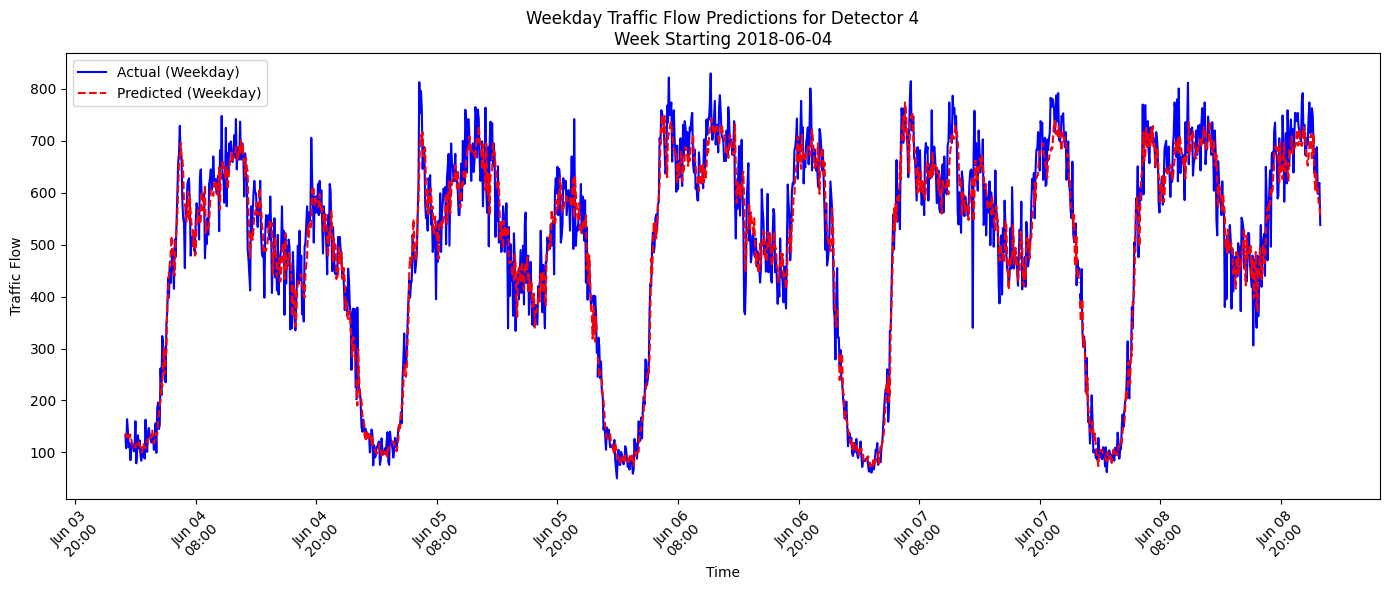

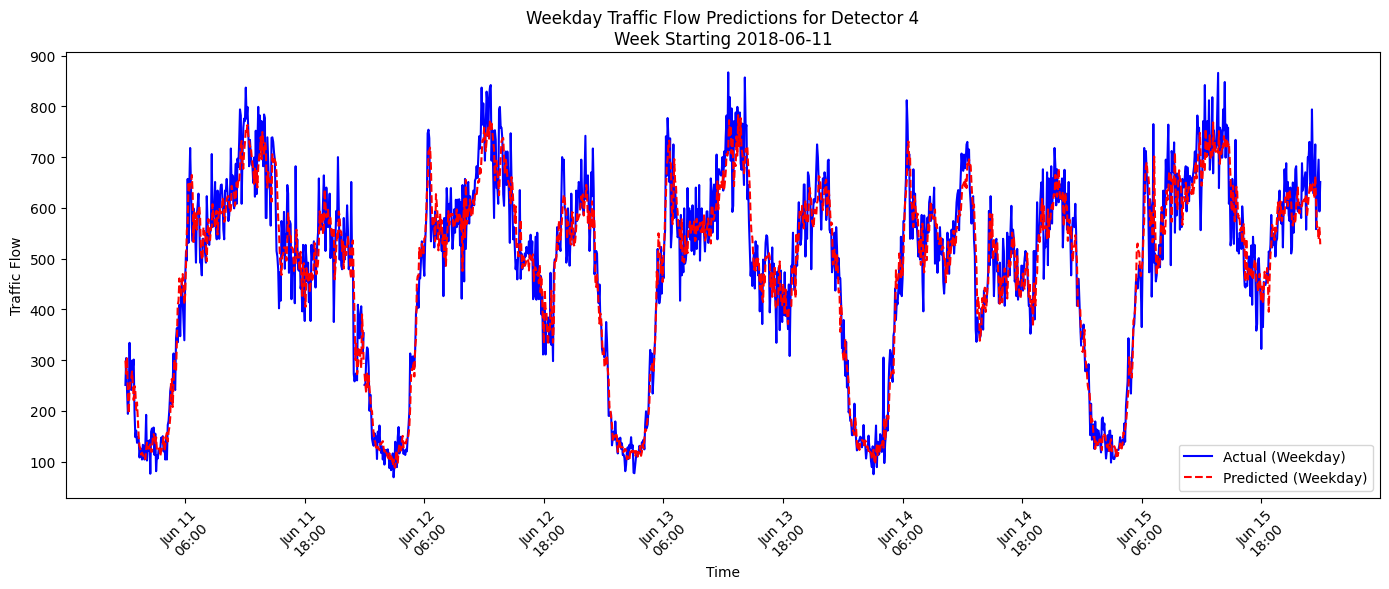

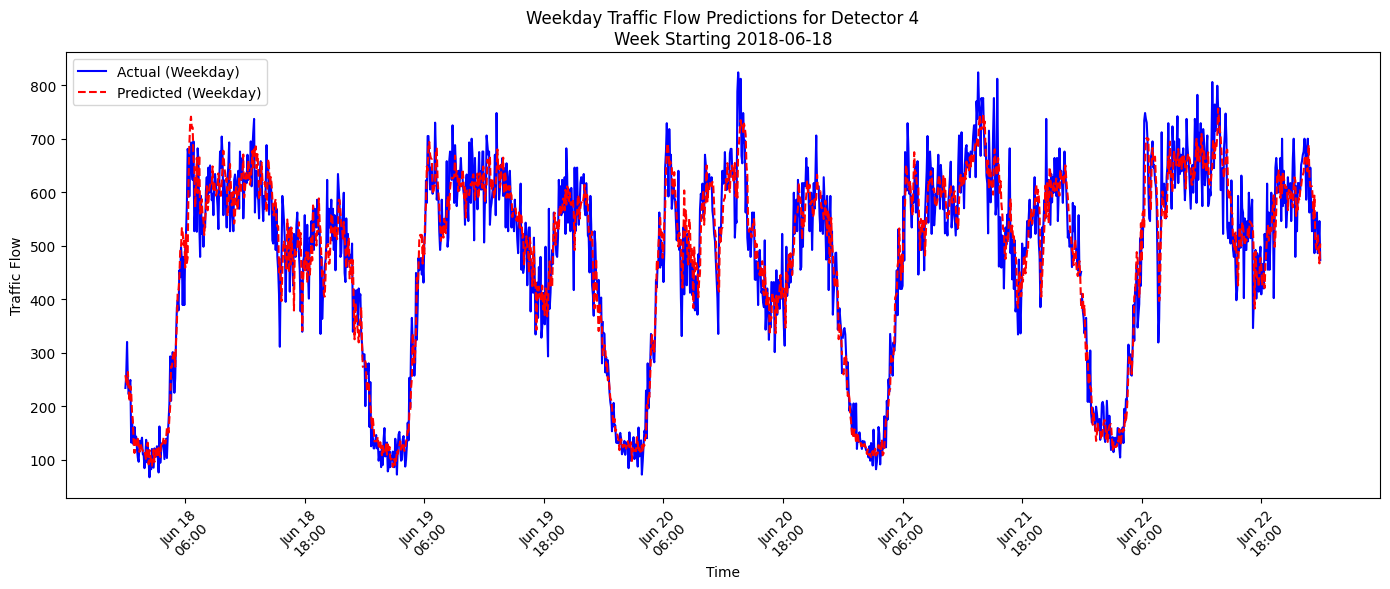

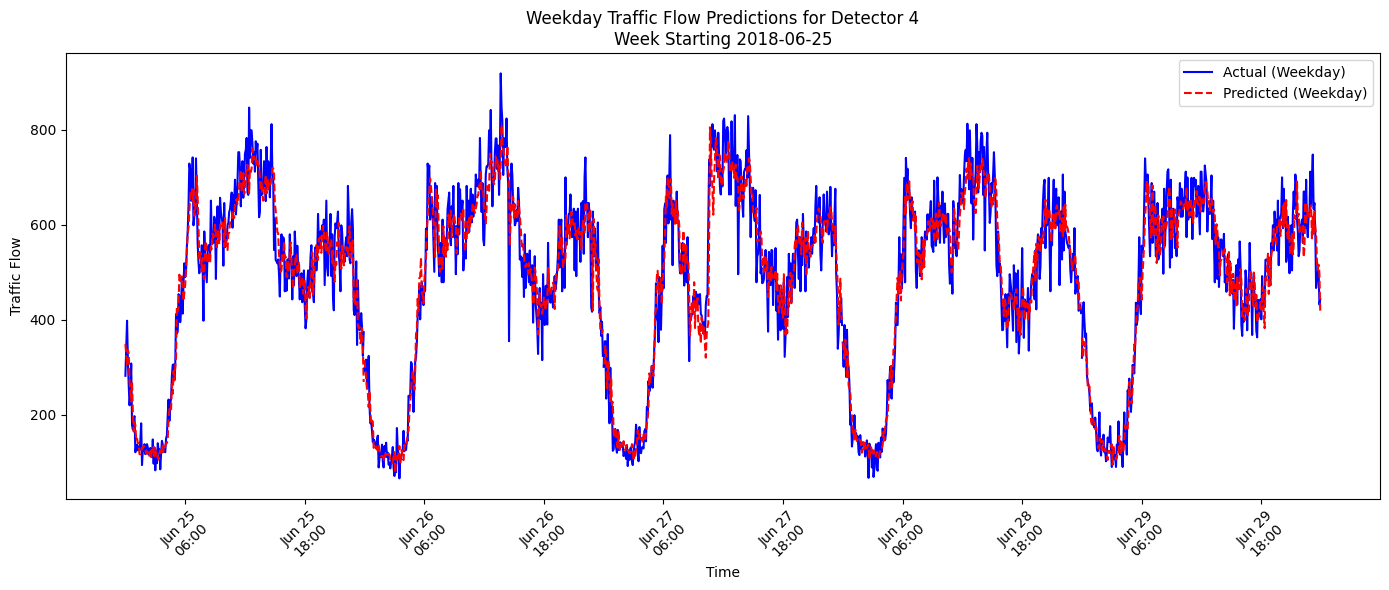

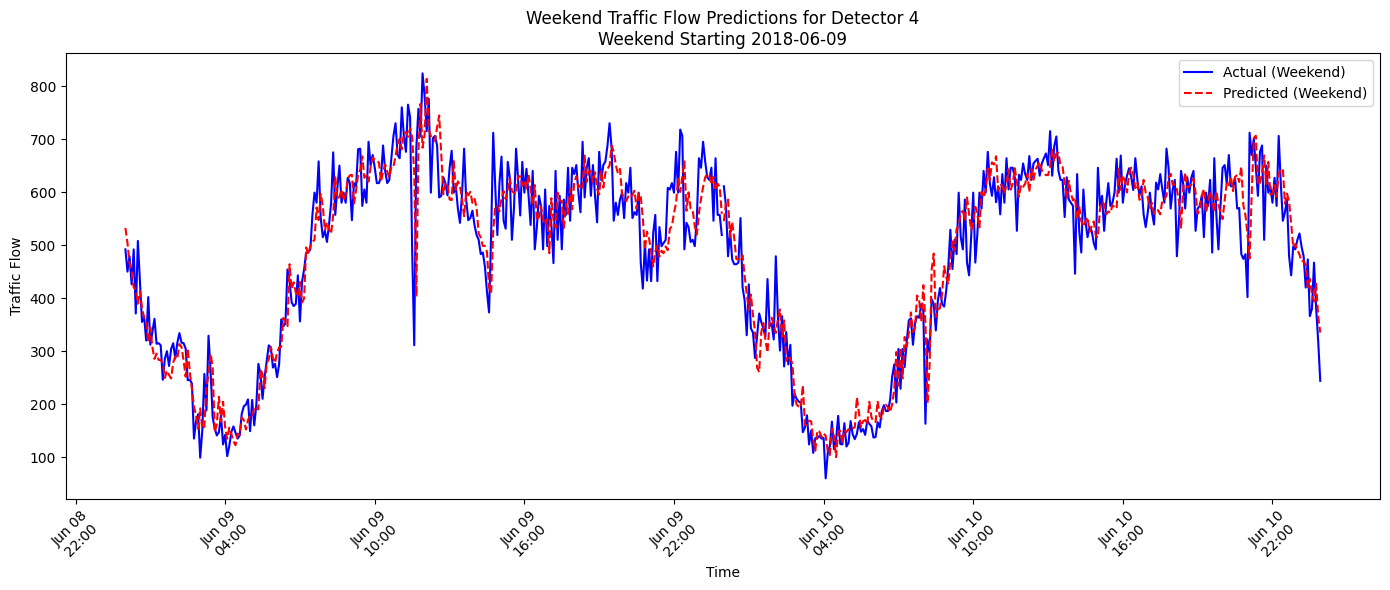

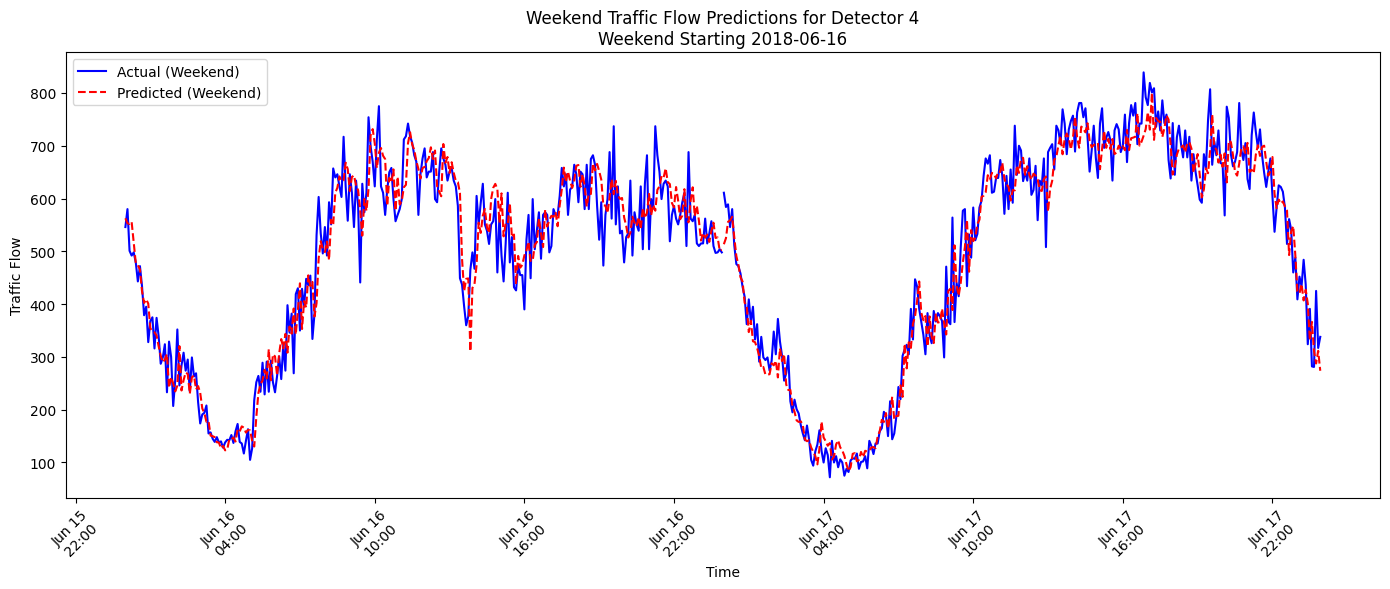

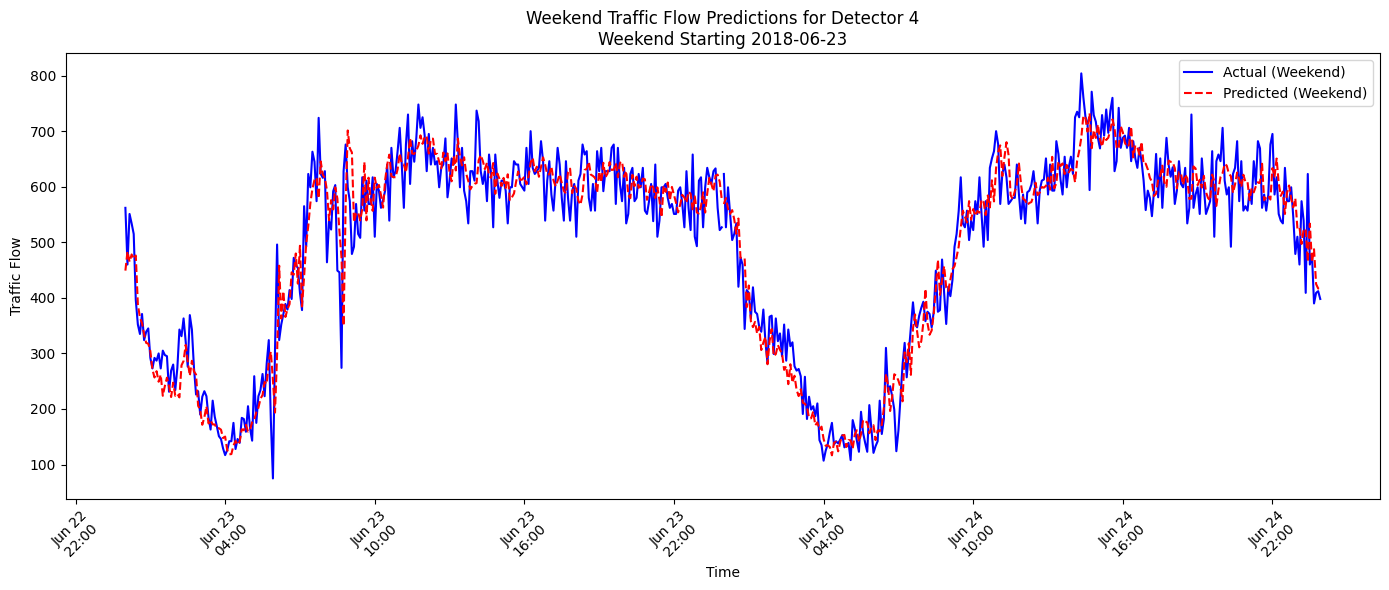

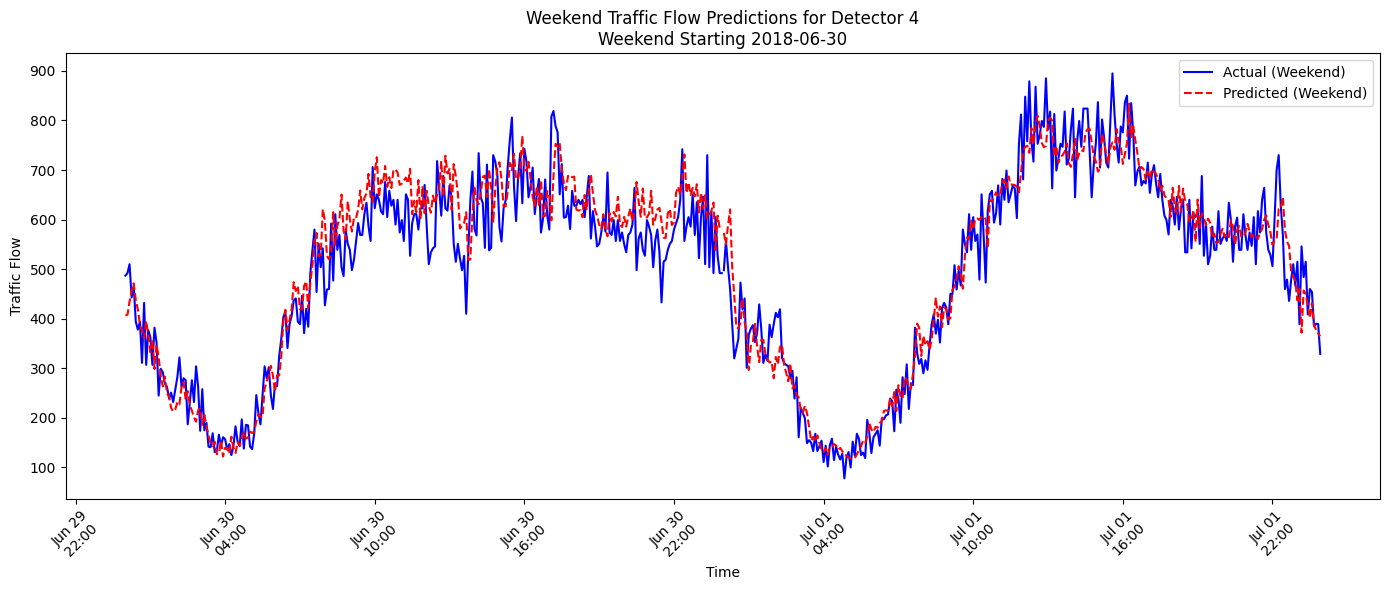

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ------------------------------
# 5. Weekday vs Weekend Analysis (If test data spans multiple days)
# ------------------------------
if len(timestamps) > n_samples_day:
    # Create df_eval with Actual/Predicted flows for Detector 1
    df_eval = pd.DataFrame({
        'Actual': y_test_rescaled[:, 3],
        'Predicted': y_pred_rescaled[:, 3]
    }, index=timestamps)

    df_eval['Residual'] = df_eval['Actual'] - df_eval['Predicted']
    df_eval['DayOfWeek'] = df_eval.index.dayofweek  # Monday=0, Sunday=6
    df_eval['Period'] = np.where(df_eval['DayOfWeek'] < 5, 'Weekday', 'Weekend')

    weekday_data = df_eval[df_eval['Period'] == 'Weekday']
    weekend_data = df_eval[df_eval['Period'] == 'Weekend']

    # Compute metrics
    mae_weekday, mre_weekday, rmse_weekday, mape_weekday = compute_error_metrics(weekday_data['Actual'], weekday_data['Predicted'])
    mae_weekend, mre_weekend, rmse_weekend, mape_weekend = compute_error_metrics(weekend_data['Actual'], weekend_data['Predicted'])

    print("\nWeekday vs Weekend Metrics for Detector 2:")
    print(f"Weekday - MAE: {mae_weekday:.2f}, MRE: {mre_weekday:.2f}, RMSE: {rmse_weekday:.2f}, MAPE: {mape_weekday:.2f}")
    print(f"Weekend - MAE: {mae_weekend:.2f}, MRE: {mre_weekend:.2f}, RMSE: {rmse_weekend:.2f}, MAPE: {mape_weekend:.2f}")

    # -------------------------
    # Plot WEEKDAY data by grouping each date separately
    # -------------------------

    daily_groups = list(weekday_data.groupby(weekday_data.index.date))

    # Define how many days constitute a week (typically 5 weekdays)
    days_per_week = 5

    # Loop over the daily groups in chunks of 5 days (one week per plot)
    for week_start in range(0, len(daily_groups), days_per_week):
        # Slice the list to get one week of data
        week_data = daily_groups[week_start:week_start + days_per_week]

        # Create a new figure for the week
        plt.figure(figsize=(14, 6))

        # Use a flag to only add legend once
        first_day = True
        for date_val, day_df in week_data:
            if first_day:
                plt.plot(day_df.index, day_df['Actual'], label='Actual (Weekday)', color='blue')
                plt.plot(day_df.index, day_df['Predicted'], label='Predicted (Weekday)', color='red', linestyle='--')
                first_day = False
            else:
                plt.plot(day_df.index, day_df['Actual'], color='blue')
                plt.plot(day_df.index, day_df['Predicted'], color='red', linestyle='--')

        # Labeling and formatting
        plt.xlabel('Time')
        plt.ylabel('Traffic Flow')

        # Use the first day's date as the week label
        week_start_date = week_data[0][0]
        plt.title(f'Weekday Traffic Flow Predictions for Detector 4\nWeek Starting {week_start_date}')

        plt.legend()

        # Improve x-axis: set major ticks every 6 hours and format ticks to show day and time
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))

        # Rotate tick labels for readability
        plt.xticks(rotation=45)

        plt.tight_layout()
        filename = f"weekday_plot_{week_start_date}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.show()

    # -------------------------
    # Plot WEEKEND data by grouping each date separately
    # -------------------------
    # Group weekend_data by date into a list of (date, dataframe)
    daily_groups = list(weekend_data.groupby(weekend_data.index.date))

    # For weekends, we expect 2 days (Saturday and Sunday)
    days_per_weekend = 2

    # Loop over the weekend groups in chunks of 2 days per plot
    for idx in range(0, len(daily_groups), days_per_weekend):
        # Slice the list to get one weekend (2 days) of data
        weekend_chunk = daily_groups[idx: idx + days_per_weekend]

        # Create a new figure for this weekend
        plt.figure(figsize=(14, 6))

        # Use a flag to add legend only once
        first_day = True
        for date_val, day_df in weekend_chunk:
            if first_day:
                plt.plot(day_df.index, day_df['Actual'], label='Actual (Weekend)', color='blue')
                plt.plot(day_df.index, day_df['Predicted'], label='Predicted (Weekend)', color='red', linestyle='--')
                first_day = False
            else:
                plt.plot(day_df.index, day_df['Actual'], color='blue')
                plt.plot(day_df.index, day_df['Predicted'], color='red', linestyle='--')

        # Labeling and formatting
        plt.xlabel('Time')
        plt.ylabel('Traffic Flow')

        # Use the first day in the chunk as the weekend label
        weekend_start_date = weekend_chunk[0][0]
        plt.title(f'Weekend Traffic Flow Predictions for Detector 4\nWeekend Starting {weekend_start_date}')
        plt.legend()

        # Improve x-axis: set major ticks every 6 hours and format ticks to show day and time
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))

        plt.xticks(rotation=45)
        plt.tight_layout()
        filename = f"weekend_plot_{weekend_start_date}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.show()




Weekday vs Weekend Metrics for Detector 4:
Weekday - MAE: 16.17, MRE: 6.53, RMSE: 21.20, MAPE: 6.53
Weekend - MAE: 23.38, MRE: 13.73, RMSE: 33.58, MAPE: 13.73


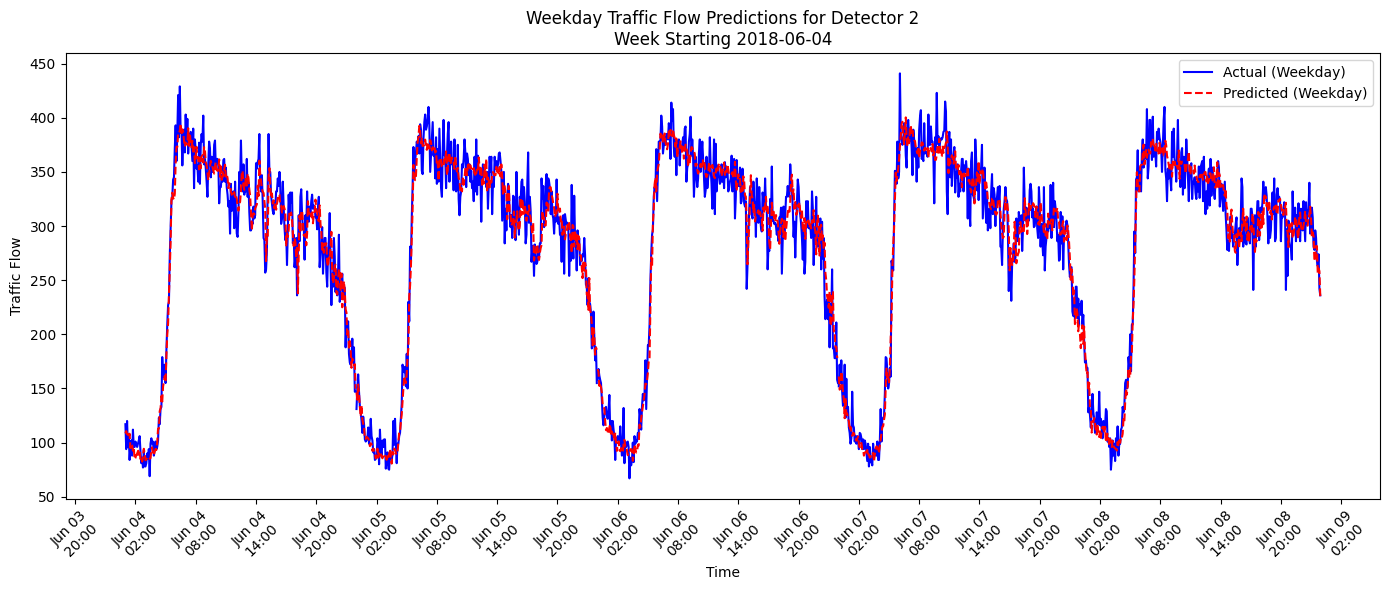

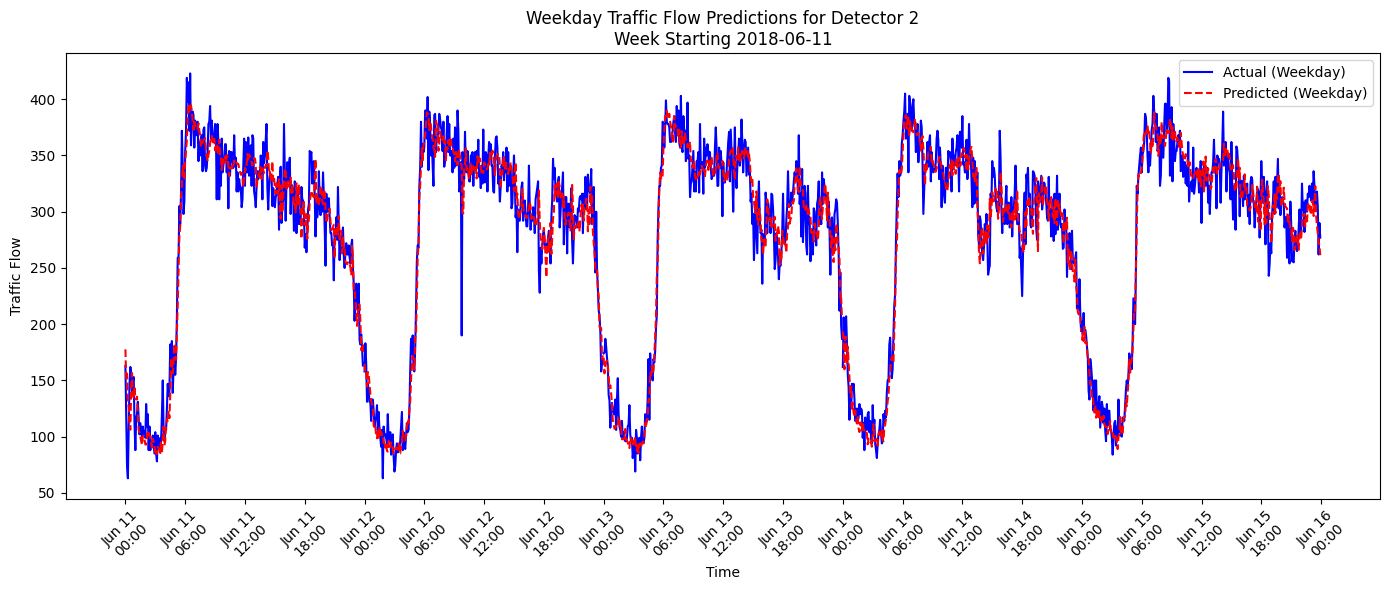

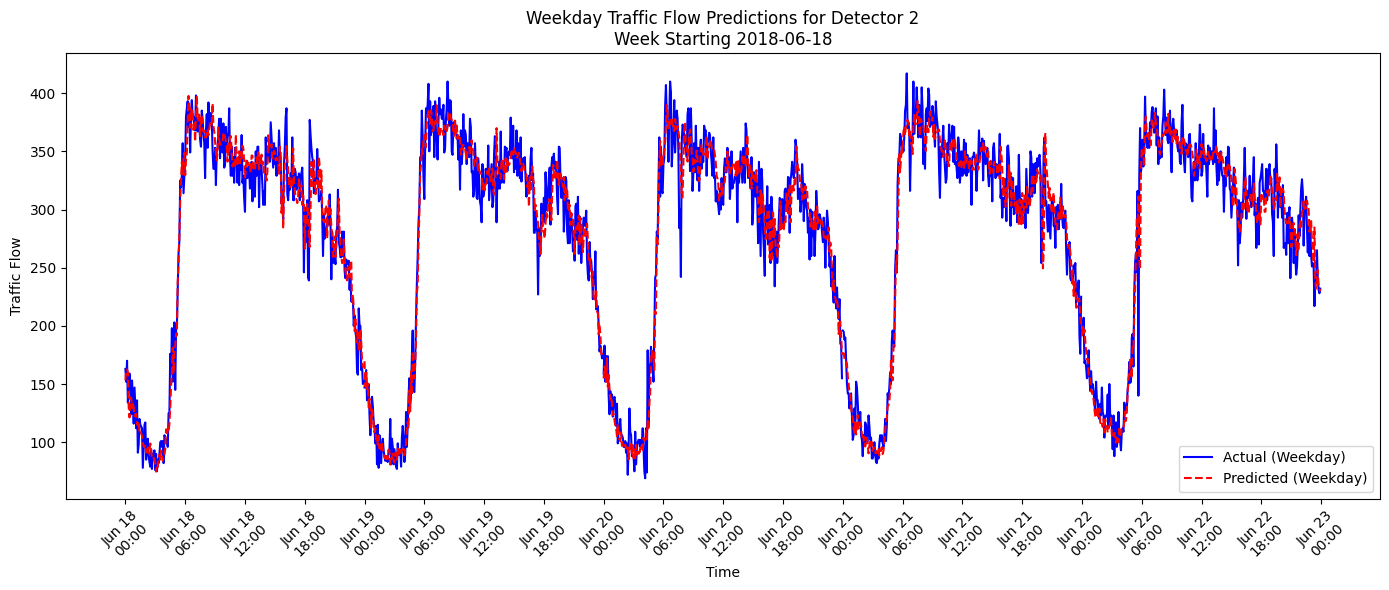

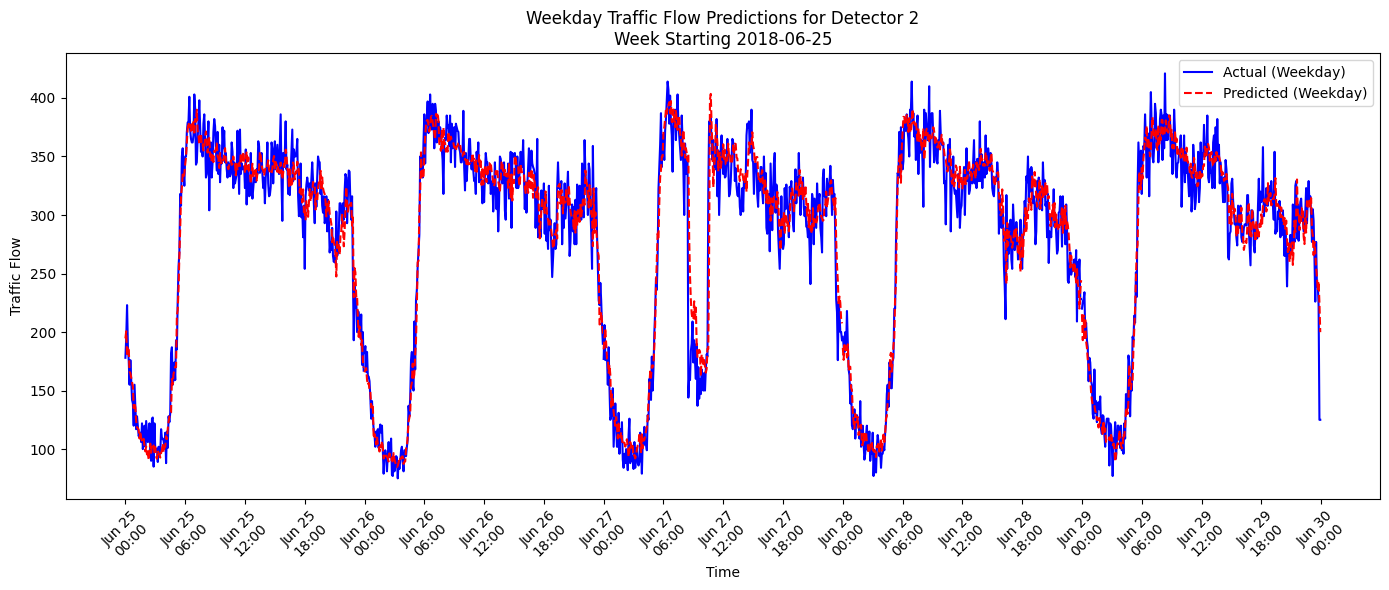

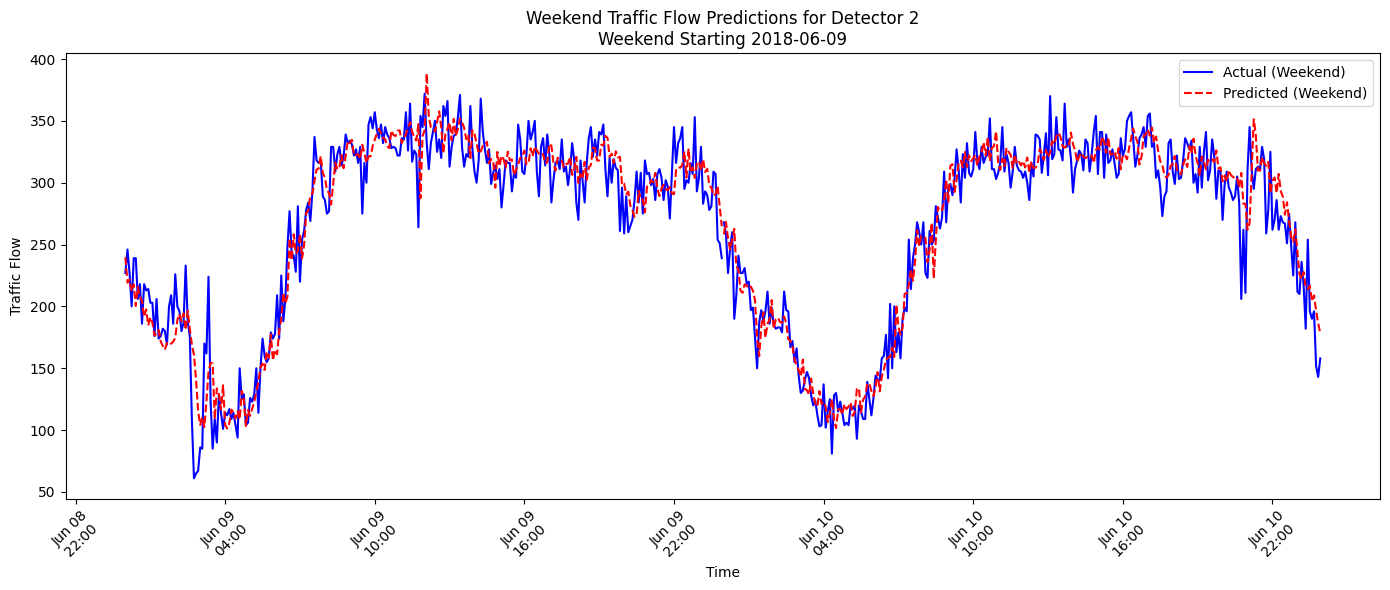

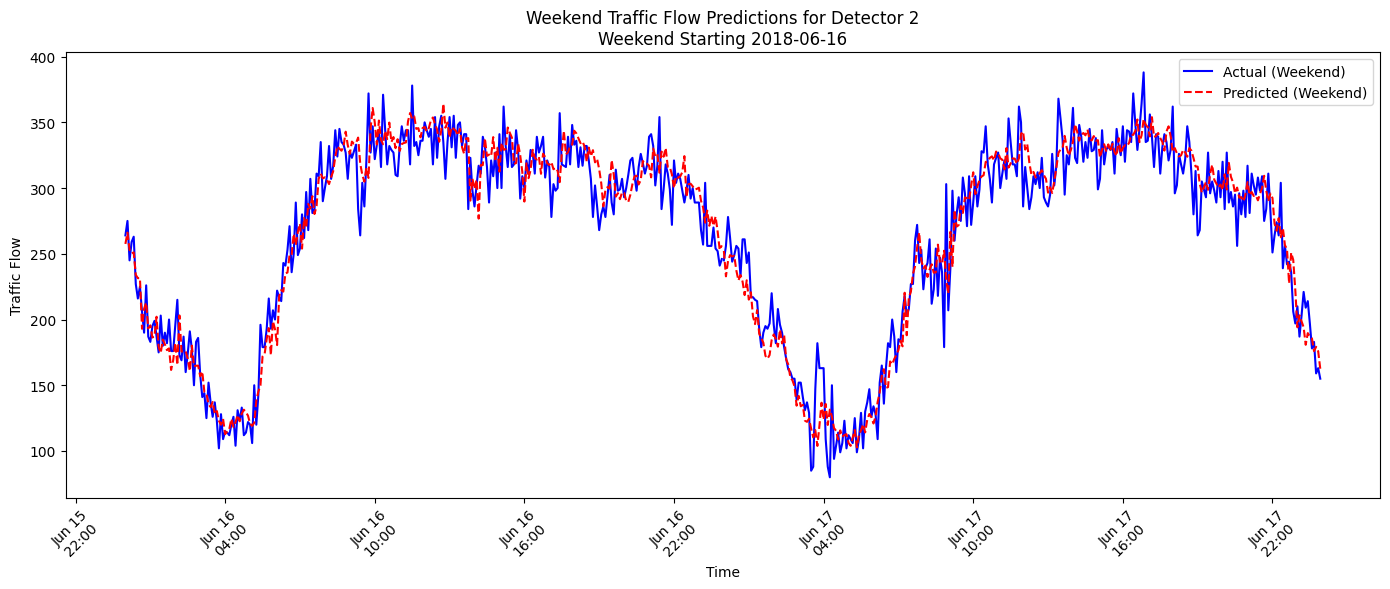

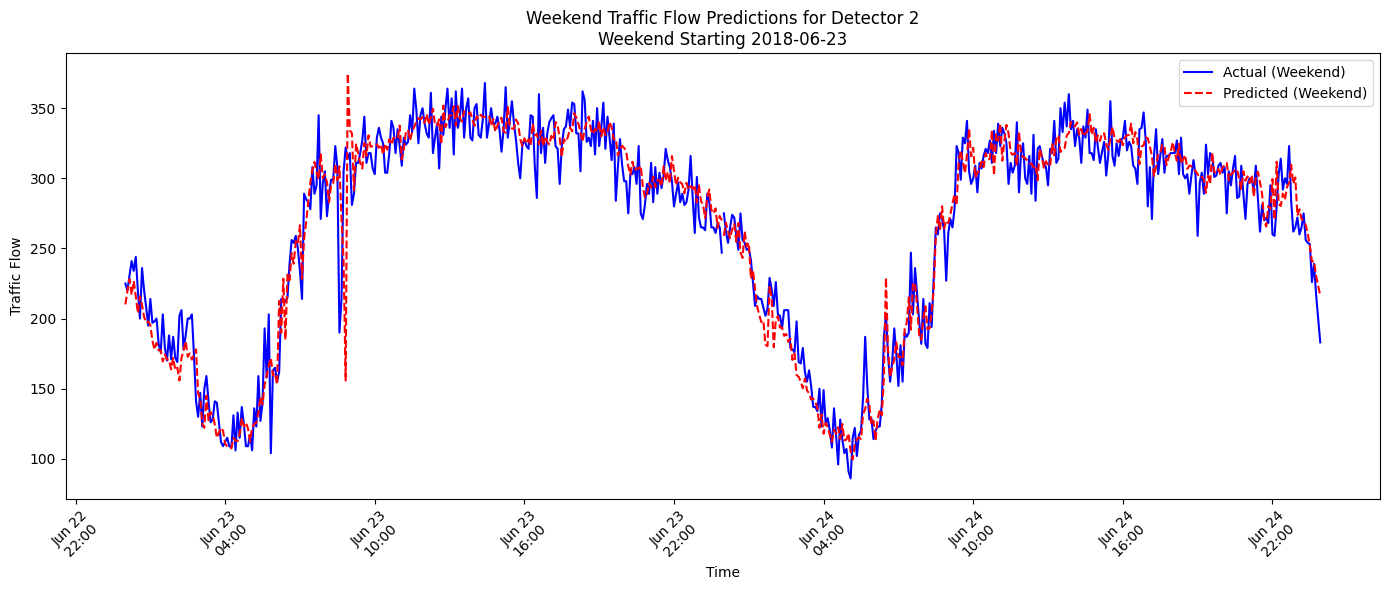

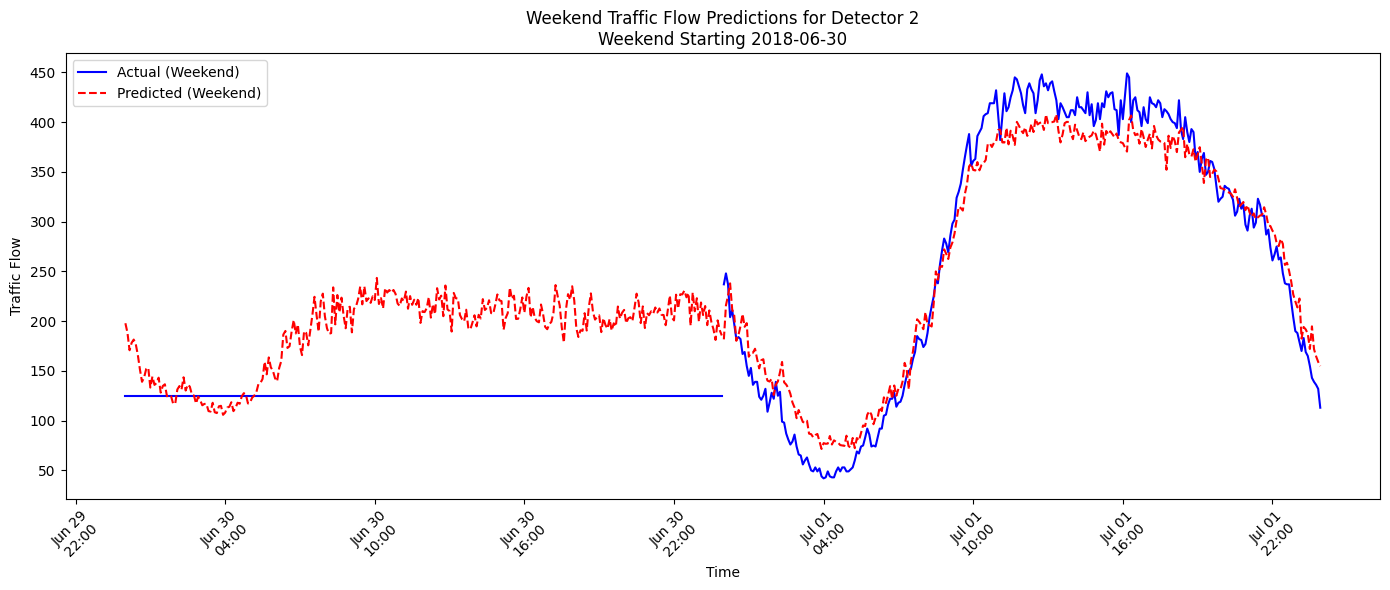

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ------------------------------
# 5. Weekday vs Weekend Analysis (If test data spans multiple days)
# ------------------------------
if len(timestamps) > n_samples_day:
    # Create df_eval with Actual/Predicted flows for Detector 1
    df_eval = pd.DataFrame({
        'Actual': y_test_rescaled[:, 1],
        'Predicted': y_pred_rescaled[:, 1]
    }, index=timestamps)

    df_eval['Residual'] = df_eval['Actual'] - df_eval['Predicted']
    df_eval['DayOfWeek'] = df_eval.index.dayofweek  # Monday=0, Sunday=6
    df_eval['Period'] = np.where(df_eval['DayOfWeek'] < 5, 'Weekday', 'Weekend')

    weekday_data = df_eval[df_eval['Period'] == 'Weekday']
    weekend_data = df_eval[df_eval['Period'] == 'Weekend']

    # Compute metrics
    mae_weekday, mre_weekday, rmse_weekday, mape_weekday = compute_error_metrics(weekday_data['Actual'], weekday_data['Predicted'])
    mae_weekend, mre_weekend, rmse_weekend, mape_weekend = compute_error_metrics(weekend_data['Actual'], weekend_data['Predicted'])

    print("\nWeekday vs Weekend Metrics for Detector 4:")
    print(f"Weekday - MAE: {mae_weekday:.2f}, MRE: {mre_weekday:.2f}, RMSE: {rmse_weekday:.2f}, MAPE: {mape_weekday:.2f}")
    print(f"Weekend - MAE: {mae_weekend:.2f}, MRE: {mre_weekend:.2f}, RMSE: {rmse_weekend:.2f}, MAPE: {mape_weekend:.2f}")

    # -------------------------
    # Plot WEEKDAY data by grouping each date separately
    # -------------------------

    daily_groups = list(weekday_data.groupby(weekday_data.index.date))

    # Define how many days constitute a week (typically 5 weekdays)
    days_per_week = 5

    # Loop over the daily groups in chunks of 5 days (one week per plot)
    for week_start in range(0, len(daily_groups), days_per_week):
        # Slice the list to get one week of data
        week_data = daily_groups[week_start:week_start + days_per_week]

        # Create a new figure for the week
        plt.figure(figsize=(14, 6))

        # Use a flag to only add legend once
        first_day = True
        for date_val, day_df in week_data:
            if first_day:
                plt.plot(day_df.index, day_df['Actual'], label='Actual (Weekday)', color='blue')
                plt.plot(day_df.index, day_df['Predicted'], label='Predicted (Weekday)', color='red', linestyle='--')
                first_day = False
            else:
                plt.plot(day_df.index, day_df['Actual'], color='blue')
                plt.plot(day_df.index, day_df['Predicted'], color='red', linestyle='--')

        # Labeling and formatting
        plt.xlabel('Time')
        plt.ylabel('Traffic Flow')

        # Use the first day's date as the week label
        week_start_date = week_data[0][0]
        plt.title(f'Weekday Traffic Flow Predictions for Detector 2\nWeek Starting {week_start_date}')

        plt.legend()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Assume you've already created your plot and have an Axes instance (e.g., ax = plt.gca())
        ax = plt.gca()

        # Set the major ticks to appear every hour
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))

        # Format the major tick labels to show day and time, for example: "Mar 10\n13:00"
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))

        # Rotate tick labels for readability
        plt.xticks(rotation=45)

        plt.tight_layout()
        filename = f"weekday_plot_{week_start_date}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.show()

    # -------------------------
    # Plot WEEKEND data by grouping each date separately
    # -------------------------
    # Group weekend_data by date into a list of (date, dataframe)
    daily_groups = list(weekend_data.groupby(weekend_data.index.date))

    # For weekends, we expect 2 days (Saturday and Sunday)
    days_per_weekend = 2

    # Loop over the weekend groups in chunks of 2 days per plot
    for idx in range(0, len(daily_groups), days_per_weekend):
        # Slice the list to get one weekend (2 days) of data
        weekend_chunk = daily_groups[idx: idx + days_per_weekend]

        # Create a new figure for this weekend
        plt.figure(figsize=(14, 6))

        # Use a flag to add legend only once
        first_day = True
        for date_val, day_df in weekend_chunk:
            if first_day:
                plt.plot(day_df.index, day_df['Actual'], label='Actual (Weekend)', color='blue')
                plt.plot(day_df.index, day_df['Predicted'], label='Predicted (Weekend)', color='red', linestyle='--')
                first_day = False
            else:
                plt.plot(day_df.index, day_df['Actual'], color='blue')
                plt.plot(day_df.index, day_df['Predicted'], color='red', linestyle='--')

        # Labeling and formatting
        plt.xlabel('Time')
        plt.ylabel('Traffic Flow')

        # Use the first day in the chunk as the weekend label
        weekend_start_date = weekend_chunk[0][0]
        plt.title(f'Weekend Traffic Flow Predictions for Detector 2\nWeekend Starting {weekend_start_date}')
        plt.legend()

        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))

        plt.xticks(rotation=45)
        plt.tight_layout()
        filename = f"weekend_plot_{weekend_start_date}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.show()



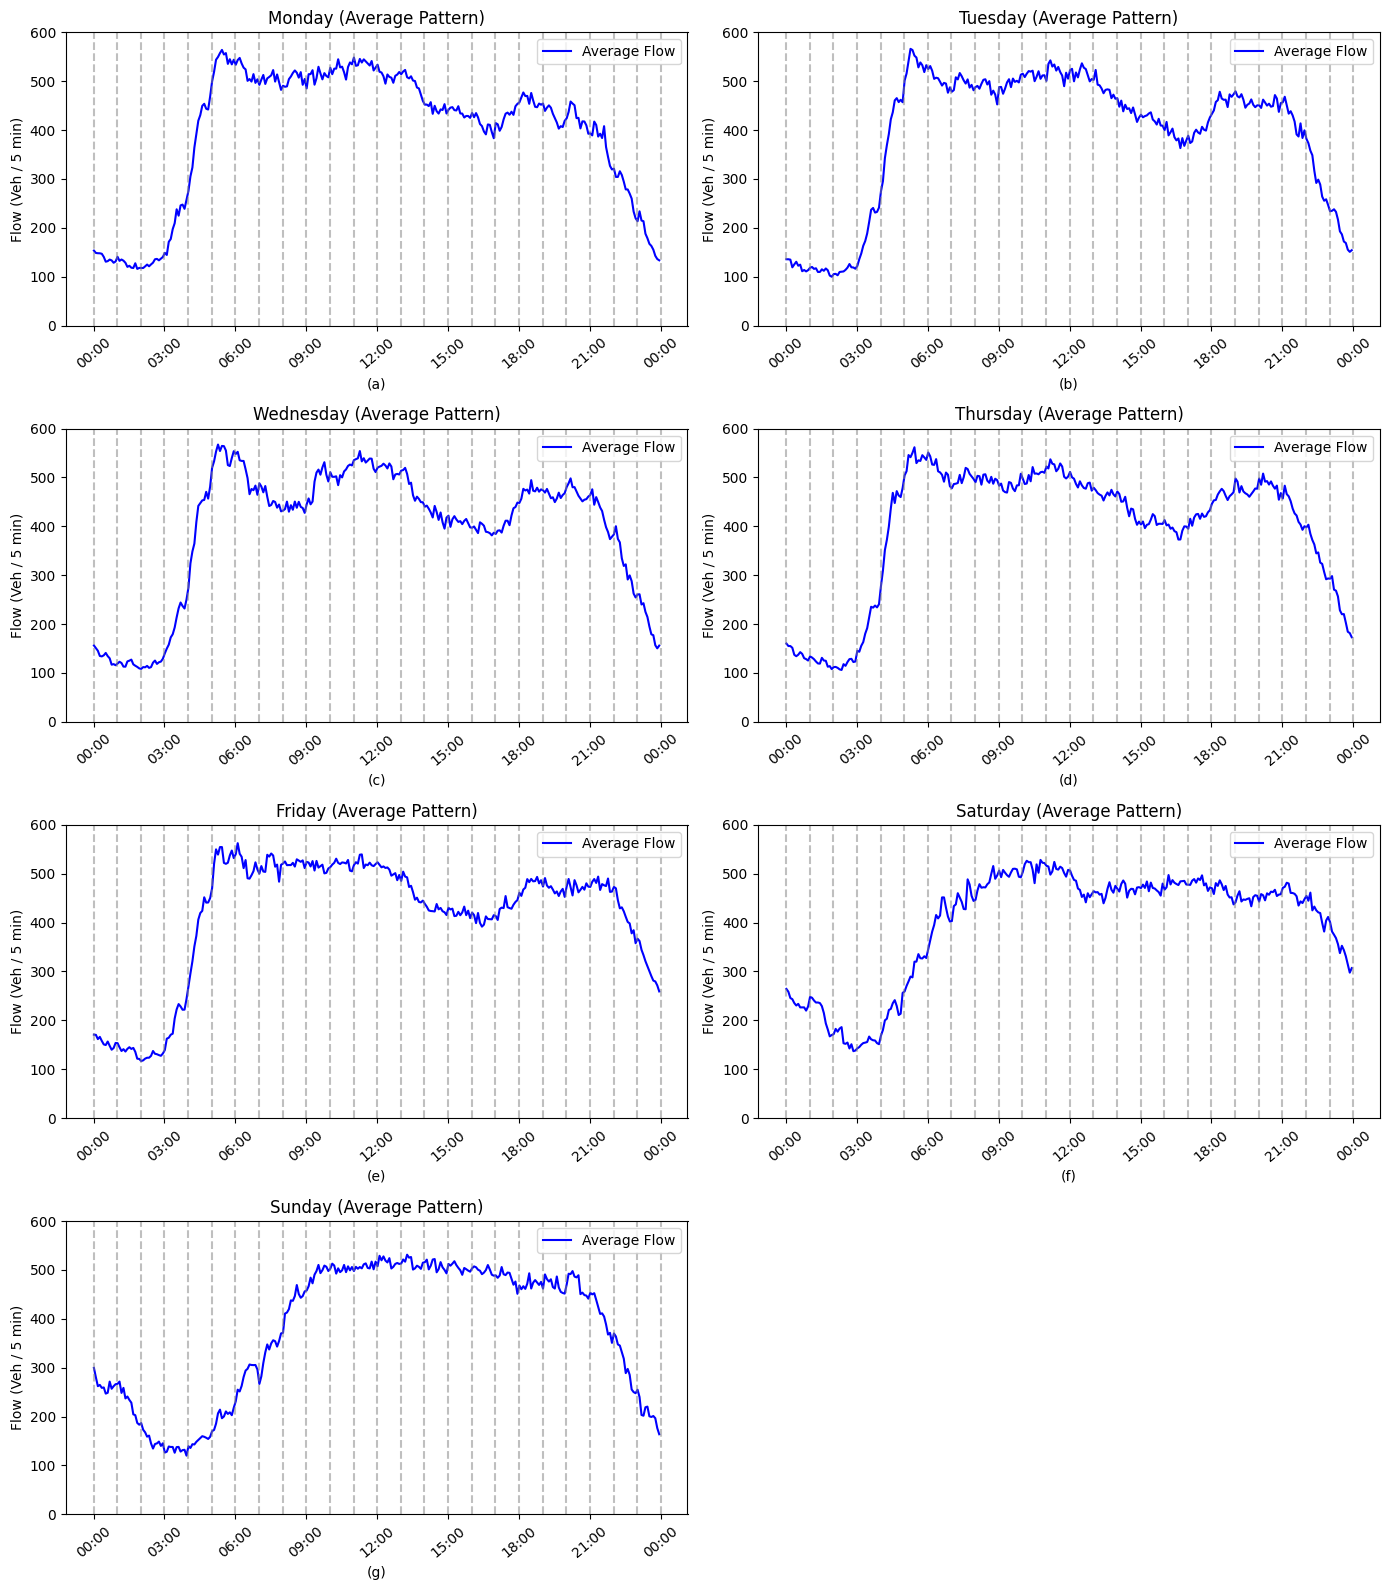

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, time


detector_cols = [f"Detector{i+1}" for i in range(5)]

# Create a DataFrame
df = pd.DataFrame(y_test_rescaled, columns=detector_cols)

# 1. Create an AverageFlow column across all detectors.
df['AverageFlow'] = df[['Detector1', 'Detector2', 'Detector3', 'Detector4', 'Detector5']].mean(axis=1)

# Create a DateTimeIndex assuming each row is 5 minutes apart.
start_time = "2018-06-04 00:01:00"
date_index = pd.date_range(start=start_time, periods=len(df), freq='5min')

# Assign the DateTimeIndex to the DataFrame
df.index = date_index

# Now you can create helper columns for day-of-week and time-of-day
df['DayOfWeek'] = df.index.dayofweek   # Monday=0, Sunday=6
df['TimeOfDay'] = df.index.time

# 3. Group by (DayOfWeek, TimeOfDay) to get the mean AverageFlow.
grouped = (
    df.groupby(['DayOfWeek', 'TimeOfDay'])['AverageFlow']
      .mean()
      .reset_index()
)

# 4. Prepare subplots. We have 7 days (0–6),
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
axes = axes.flatten()

# Dictionary to map numeric day to weekday name
days_map = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}

abc = {
    0: 'a', 1: 'b', 2: 'c',
    3: 'd', 4: 'e', 5: 'f',
    6: 'g'
}


# 5. Plot each day in a separate subplot.
for day_idx in range(7):
    ax = axes[day_idx]
    day_name = days_map[day_idx]
    index = abc[day_idx]

    # Filter the grouped data for the specific day of week
    day_data = grouped[grouped['DayOfWeek'] == day_idx].copy()

    day_data['TimeAsDatetime'] = day_data['TimeOfDay'].apply(
        lambda t: datetime.combine(date(2018, 6, 4), t)
    )

    # Sort by this new datetime to ensure correct chronological order
    day_data.sort_values('TimeAsDatetime', inplace=True)

    # Plot the average flow over the day
    ax.plot(day_data['TimeAsDatetime'], day_data['AverageFlow'], label='Average Flow', color='blue')

    for hour in range(0, 24):
        ax.axvline(datetime(2018,6,4,hour), color='gray', linestyle='--', alpha=0.5)
    ax.axvline(datetime(2018,6,5,0), color='gray', linestyle='--', alpha=0.5)

    # Format the x-axis to show only HH:MM
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Set labels and title
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=40, ha='center')
    ax.set_ylim(0, 600)
    ax.set_title(f'{day_name} (Average Pattern)')
    ax.set_xlabel("(" + index + ")")
    ax.set_ylabel('Flow (Veh / 5 min)')
    ax.legend()

# Remove the unused 8th subplot (the last axis in the grid)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig("average_flow_plots.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Compute residuals: shape (N, 5)
residuals = y_test_rescaled - y_pred_rescaled

# Build a DataFrame for easier analysis
df_res = pd.DataFrame(
    data=residuals,
    columns=[f"Detector{i+1}" for i in range(5)],
    index=timestamps
)

# Optionally, add convenience columns (like day of week, hour) for grouping.
df_res["DayOfWeek"] = df_res.index.dayofweek    # Monday=0, Sunday=6
df_res["Hour"] = df_res.index.hour


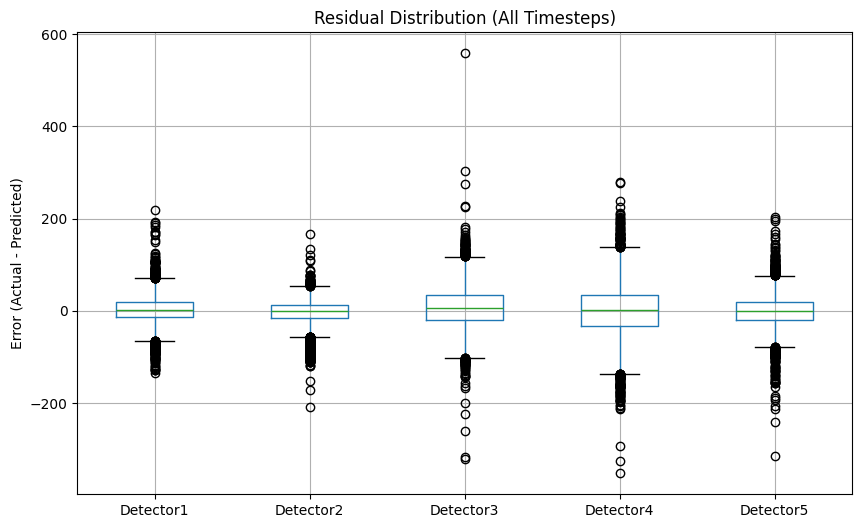

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_res[["Detector1", "Detector2", "Detector3", "Detector4", "Detector5"]].boxplot()
plt.title("Residual Distribution (All Timesteps)")
plt.ylabel("Error (Actual - Predicted)")
plt.savefig("boxplots.png", dpi=300, bbox_inches='tight')
plt.show()


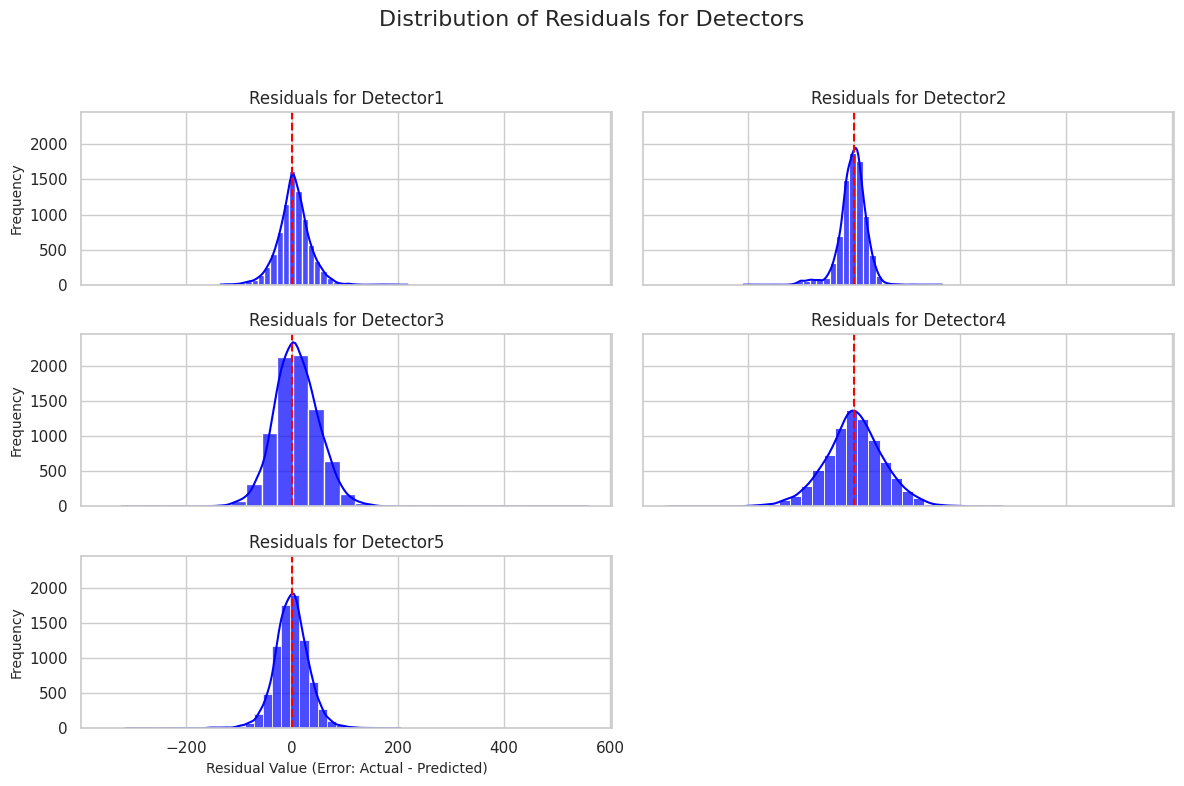

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style for the plots
sns.set_theme(style="whitegrid")

# List of detectors
detectors = ["Detector1", "Detector2", "Detector3", "Detector4", "Detector5"]

fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, detector in enumerate(detectors):
    sns.histplot(df_res[detector], bins=30, kde=True, color='blue', alpha=0.7, ax=axes[i])
    axes[i].axvline(x=0, color='red', linestyle='dashed', linewidth=1.5)
    axes[i].set_title(f"Residuals for {detector}", fontsize=12)
    axes[i].set_xlabel("Residual Value (Error: Actual - Predicted)", fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)

if len(axes) > len(detectors):
    for j in range(len(detectors), len(axes)):
        fig.delaxes(axes[j])

# Add a main title and adjust layout to avoid overlapping with the suptitle
plt.suptitle("Distribution of Residuals for Detectors", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("histogram.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1000x600 with 0 Axes>

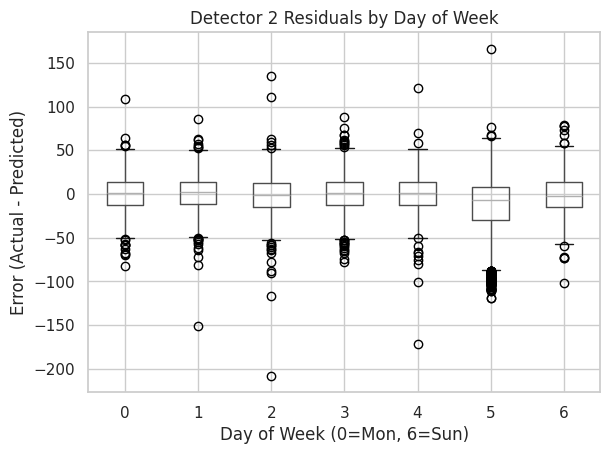

In [ ]:
# Example: Box plot for Detector 1’s residuals by day of week
plt.figure(figsize=(10, 6))
df_res.boxplot(column="Detector2", by="DayOfWeek", grid=True)
plt.title("Detector 2 Residuals by Day of Week")
plt.suptitle("")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Error (Actual - Predicted)")
plt.savefig("box_plots.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1200x600 with 0 Axes>

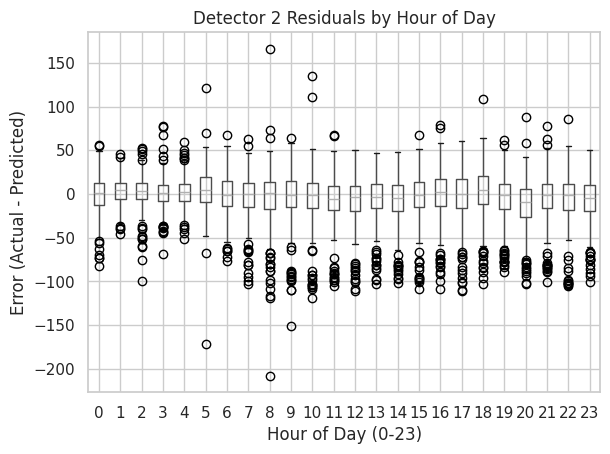

In [ ]:
# Group by Hour and compute summary statistics
hourly_stats = df_res.groupby("Hour")[["Detector1", "Detector2", "Detector3", "Detector4", "Detector5"]].describe()

# Or a box plot for Detector 1 by Hour
plt.figure(figsize=(12, 6))
df_res.boxplot(column="Detector2", by="Hour", grid=True)
plt.title("Detector 2 Residuals by Hour of Day")
plt.suptitle("")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Error (Actual - Predicted)")
plt.savefig("box_plots_hod.png", dpi=300, bbox_inches='tight')
plt.show()


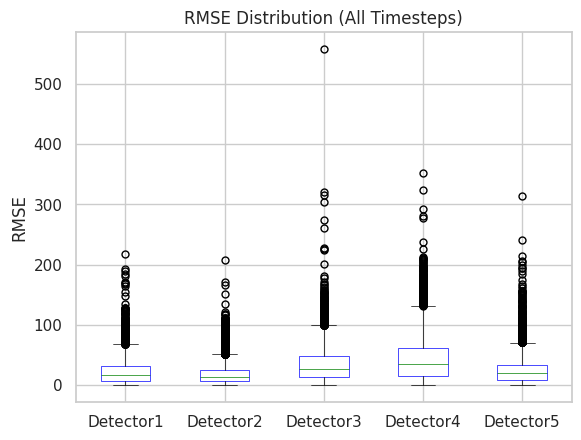

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n_samples_day = 275 + (287*6)

# Compute RMSE at each timestamp (row-wise across all detectors)
rmse = np.sqrt((y_test_rescaled[:] - y_pred_rescaled[:]) ** 2)

# Build a DataFrame for easier analysis
df_rmse = pd.DataFrame(
    data=rmse,
    columns=[f"Detector{i+1}" for i in range(5)],
    index=timestamps[:]
)

df_rmse["DayOfWeek"] = df_rmse.index.dayofweek    # Monday=0, Sunday=6
df_rmse["Hour"] = df_rmse.index.hour

boxplot = df_rmse.boxplot(
    column=["Detector1", "Detector2", "Detector3", "Detector4", "Detector5"],
    grid=True,
    patch_artist=True,  # Allows facecolor filling
    boxprops=dict(facecolor='white', edgecolor='blue', linewidth=0.5),  # White box, blue outline
    whiskerprops=dict(color='black', linewidth=0.5),  # Whisker color
    capprops=dict(color='black', linewidth=0.5),  # Cap line color
    medianprops=dict(color='green', linewidth=0.5),  # Green median line
    flierprops=dict(marker='o', color='black', markersize=5)  # Outliers
)

# Create a box plot of RMSE distribution
plt.title("RMSE Distribution (All Timesteps)")
plt.ylabel("RMSE")
plt.savefig("rmse_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()


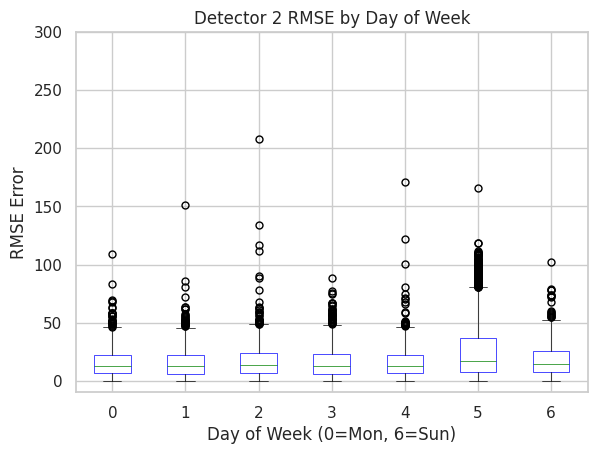

In [ ]:
# Example: Box plot for Detector 1’s residuals by day of week

boxplot = df_rmse.boxplot(
    column="Detector2",
    by="DayOfWeek",
    grid=True,
    patch_artist=True,  # Allows facecolor filling
    boxprops=dict(facecolor='white', edgecolor='blue', linewidth=0.5),  # White box, blue outline
    whiskerprops=dict(color='black', linewidth=0.5),  # Whisker color
    capprops=dict(color='black', linewidth=0.5),  # Cap line color
    medianprops=dict(color='green', linewidth=0.5),  # Green median line
    flierprops=dict(marker='o', color='black', markersize=5)  # Outliers
)

plt.title("Detector 2 RMSE by Day of Week")
plt.suptitle("")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
ax = plt.gca()
ax.set_ylim([-10, 300])
plt.ylabel("RMSE Error")
plt.savefig("box_plots_dow_2.png", dpi=300, bbox_inches='tight')
plt.show()


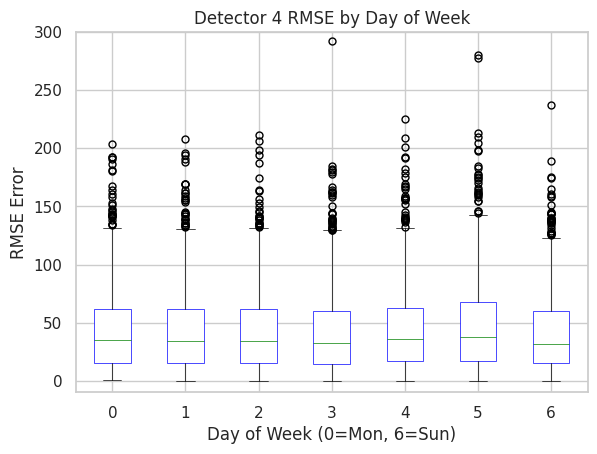

In [ ]:
# Example: Box plot for Detector 1’s residuals by day of week
boxplot = df_rmse.boxplot(
    column="Detector4",
    by="DayOfWeek",
    grid=True,
    patch_artist=True,  # Allows facecolor filling
    boxprops=dict(facecolor='white', edgecolor='blue', linewidth=0.5),  # White box, blue outline
    whiskerprops=dict(color='black', linewidth=0.5),  # Whisker color
    capprops=dict(color='black', linewidth=0.5),  # Cap line color
    medianprops=dict(color='green', linewidth=0.5),  # Green median line
    flierprops=dict(marker='o', color='black', markersize=5)  # Outliers
)
plt.title("Detector 4 RMSE by Day of Week")
plt.suptitle("")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
ax = plt.gca()
ax.set_ylim([-10, 300])
plt.ylabel("RMSE Error")
plt.savefig("box_plots_dow_4.png", dpi=300, bbox_inches='tight')
plt.show()


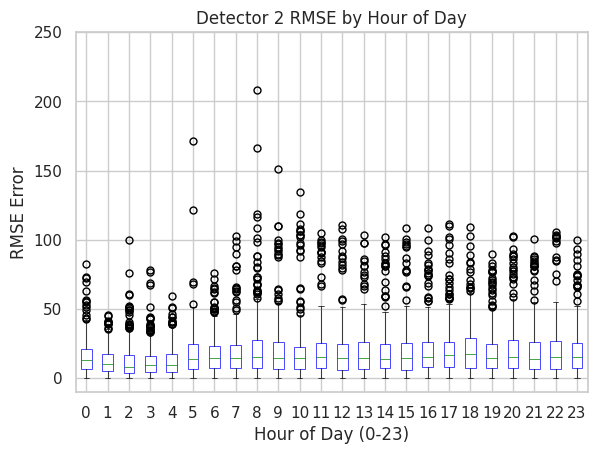

In [ ]:
# Group by Hour and compute summary statistics
hourly_stats = df_rmse.groupby("Hour")[["Detector1", "Detector2", "Detector3", "Detector4", "Detector5"]].describe()


boxplot = df_rmse.boxplot(
    column="Detector2",
    by="Hour",
    grid=True,
    patch_artist=True,  # Allows facecolor filling
    boxprops=dict(facecolor='white', edgecolor='blue', linewidth=0.5),  # White box, blue outline
    whiskerprops=dict(color='black', linewidth=0.5),  # Whisker color
    capprops=dict(color='black', linewidth=0.5),  # Cap line color
    medianprops=dict(color='green', linewidth=0.5),  # Green median line
    flierprops=dict(marker='o', color='black', markersize=5)  # Outliers
)
# Or a box plot for Detector 1 by Hour
plt.title("Detector 2 RMSE by Hour of Day")
plt.suptitle("")
plt.xlabel("Hour of Day (0-23)")
ax = plt.gca()
ax.set_ylim([-10, 250])
plt.ylabel("RMSE Error")
plt.savefig("box_plots_hod_2.png", dpi=300, bbox_inches='tight')
plt.show()


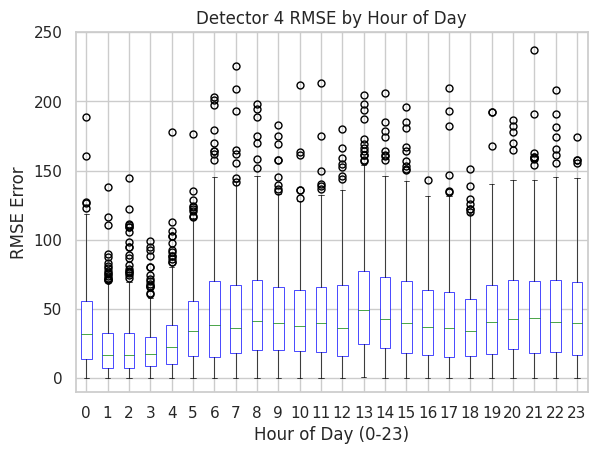

In [ ]:
# Or a box plot for Detector 1 by Hour
boxplot = df_rmse.boxplot(
    column="Detector4",
    by="Hour",
    grid=True,
    patch_artist=True,  # Allows facecolor filling
    boxprops=dict(facecolor='white', edgecolor='blue', linewidth=0.5),  # White box, blue outline
    whiskerprops=dict(color='black', linewidth=0.5),  # Whisker color
    capprops=dict(color='black', linewidth=0.5),  # Cap line color
    medianprops=dict(color='green', linewidth=0.5),  # Green median line
    flierprops=dict(marker='o', color='black', markersize=5)  # Outliers
)

plt.title("Detector 4 RMSE by Hour of Day")
plt.suptitle("")
ax = plt.gca()
ax.set_ylim([-10, 250])
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("RMSE Error")
plt.savefig("box_plots_hod_4.png", dpi=300, bbox_inches='tight')
plt.show()